<b>Telecom-Churn-Analysis</b>

<b> Business Problem</b>
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

So we need to analyse telecom industry data and predict high value customers who are at high risk of churn and identify main indicators of churn

<b> Churn Definition :</b> Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time. In our analysis we are concentrating on high value customers, as approximately 80% of revenue comes from the top 20% customers. Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.

Our dataset is divided into 3 phases:
Good phase wherein the customer is happy with the service
Action pase wherein the customer wasn't happy with service or got a better offer from competitor etc. In this phase, the customer usually shows different behaviour than the good phase. Also, it is crucial to identify high-churn-risk customers in this phase, so that some corrective actions can be taken at this point to prevet churn
Churn phase wherein the customer would have churned

High-value customers are those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).
After identifying high value customers, we will tag churn customers based on those who have not made any calls (either incoming or outgoing) and have not used mobile internet even once in the churn phase.

Let's first identify high-value customers

In [47]:
# Libraries
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn import model_selection
#from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#System 
import os
import warnings

warnings.filterwarnings('ignore')

In [48]:
#Load data set
telecom_dataset=pd.read_csv("telecom_churn_data.csv")
#Summary Information of the data set
telecom_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [49]:
telecom_dataset.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109            0.00            0.00            0.00   
1     7001865778        109            0.00            0.00            0.00   
2     7001625959        109            0.00            0.00            0.00   
3     7001204172        109            0.00            0.00            0.00   
4     7000142493        109            0.00            0.00            0.00   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9  arpu_6  ...  sachet_3g_9  fb_user_6  fb_user_7  \
0            9/30/2014  197.38  ...            0       1.00       1.00   
1            9/30/2014   34.05  ...            0        nan       1.00   
2            9/30/2014  167.69  ...            0        nan        nan   
3            9/30/2014  221.34  ...            0        nan        nan   
4            9/30/2014  261.64  ...            0       0.00        nan   

   fb_user_8  fb_user_9   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  sep_vbc_3g  
0       1.00        nan   968       30.40        0.00      101.20        3.58  
1       1.00        nan  1006        0.00        0.00        0.00        0.00  
2        nan       1.00  1103        0.00        0.00        4.17        0.00  
3        nan        nan  2491        0.00        0.00        0.00        0.00  
4        nan        nan  1526        0.00        0.00        0.00        0.00  

[5 rows x 226 columns]

In [50]:
telecom_dataset.shape

(99999, 226)

<b>Understanding Customer Behaviour During Churn</b>
Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :<br>

<li>The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.</li>
<br>
<li>The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)</li>
<br>
<li>The ‘churn’ phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.</li>
<br><br>
 

In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

 


High-value customers are those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).
After identifying high value customers, we will tag churn customers based on those who have not made any calls (either incoming or outgoing) and have not used mobile internet even once in the churn phase.

Let's first identify high-value customers

In [51]:
telecom_dataset['total_data_rech_6'] = telecom_dataset['total_rech_data_6'] * telecom_dataset['av_rech_amt_data_6']
telecom_dataset['total_data_rech_7'] = telecom_dataset['total_rech_data_7'] * telecom_dataset['av_rech_amt_data_7']

telecom_dataset['amt_data_6'] = telecom_dataset[['total_rech_amt_6','total_data_rech_6']].sum(axis=1)
telecom_dataset['amt_data_7'] = telecom_dataset[['total_rech_amt_7','total_data_rech_7']].sum(axis=1)

telecom_dataset['AVG_amt_data_6_7'] = telecom_dataset[['amt_data_6','amt_data_7']].mean(axis=1)

In [52]:
telecom_dataset.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109            0.00            0.00            0.00   
1     7001865778        109            0.00            0.00            0.00   
2     7001625959        109            0.00            0.00            0.00   
3     7001204172        109            0.00            0.00            0.00   
4     7000142493        109            0.00            0.00            0.00   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9  arpu_6  ...   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  \
0            9/30/2014  197.38  ...   968       30.40        0.00      101.20   
1            9/30/2014   34.05  ...  1006        0.00        0.00        0.00   
2            9/30/2014  167.69  ...  1103        0.00        0.00        4.17   
3            9/30/2014  221.34  ...  2491        0.00        0.00        0.00   
4            9/30/2014  261.64  ...  1526        0.00        0.00        0.00   

   sep_vbc_3g  total_data_rech_6  total_data_rech_7  amt_data_6  amt_data_7  \
0        3.58             252.00             252.00      614.00      504.00   
1        0.00                nan             154.00       74.00      538.00   
2        0.00                nan                nan      168.00      315.00   
3        0.00                nan                nan      230.00      310.00   
4        0.00              56.00                nan      252.00      350.00   

   AVG_amt_data_6_7  
0            559.00  
1            306.00  
2            241.50  
3            270.00  
4            301.00  

[5 rows x 231 columns]

In [53]:

telecom_dataset[['total_rech_amt_6','total_rech_amt_7','AVG_amt_data_6_7']].quantile(np.linspace(.1, 1, 9, 0))

total_rech_amt_6  total_rech_amt_7  AVG_amt_data_6_7
0.10              0.00              0.00             60.00
0.20             80.00             65.00            108.50
0.30            120.00            110.00            155.00
0.40            170.00            160.00            209.50
0.50            230.00            220.00            275.00
0.60            290.00            283.00            360.00
0.70            378.00            370.00            478.00
0.80            504.00            500.00            656.50
0.90            732.00            731.00           1028.00

As per the definition of high value customers are those whose recharge amount should be more than or equal to 70th percentile.
<br>
But if we use greater than or equal to, we end up getting a little above 30K records as against to 29.9K records.<br><br>
So, if we conisder only greater than, then we get 29.9K records.
Therefore we have considered greater than to filter high value customers

In [54]:
df = telecom_dataset[(telecom_dataset['AVG_amt_data_6_7']> telecom_dataset['AVG_amt_data_6_7'].quantile(0.7))]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29953 entries, 0 to 99997
Columns: 231 entries, mobile_number to AVG_amt_data_6_7
dtypes: float64(184), int64(35), object(12)
memory usage: 53.0+ MB


<b>Churn customers</b>

Let's identifying churn high value customers based on the last month i.e. month 9

In [55]:
df['churn_flag'] = np.where(
                            ((df['total_ic_mou_9'] == 0.00) | (df['total_og_mou_9'] == 0.00))
                            & ((df['vol_2g_mb_9'] == 0.00) | (df['vol_3g_mb_9'] == 0.00))
                            , 1, 0
                           )

In [56]:
print(df['churn_flag'].value_counts())
print(df['churn_flag'].value_counts()/df.shape[0])

0    26698
1     3255
Name: churn_flag, dtype: int64
0   0.89
1   0.11
Name: churn_flag, dtype: float64


Let's drop all features related to churn phase i.e. 9th month

In [57]:
df = df.drop(df.filter(regex='_9|sep', axis = 1).columns, axis=1)
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29953 entries, 0 to 99997
Data columns (total 177 columns):
mobile_number               29953 non-null int64
circle_id                   29953 non-null int64
loc_og_t2o_mou              29730 non-null float64
std_og_t2o_mou              29730 non-null float64
loc_ic_t2o_mou              29730 non-null float64
last_date_of_month_6        29953 non-null object
last_date_of_month_7        29926 non-null object
last_date_of_month_8        29788 non-null object
arpu_6                      29953 non-null float64
arpu_7                      29953 non-null float64
arpu_8                      29953 non-null float64
onnet_mou_6                 29411 non-null float64
onnet_mou_7                 29417 non-null float64
onnet_mou_8                 28781 non-null float64
offnet_mou_6                29411 non-null float64
offnet_mou_7                29417 non-null float64
offnet_mou_8                28781 non-null float64
roam_ic_mou_6               29

<b><ol>Preprocess data (convert columns to appropriate formats, handle missing values, etc.)</b></ol>

In [58]:
#Check for missing values in data set
df.isna().sum()

mobile_number            0
circle_id                0
loc_og_t2o_mou         223
std_og_t2o_mou         223
loc_ic_t2o_mou         223
                     ...  
total_data_rech_7    12915
amt_data_6               0
amt_data_7               0
AVG_amt_data_6_7         0
churn_flag               0
Length: 177, dtype: int64

In [59]:
# Let's identifyhow many missing values are there & also get their percencentages
pd.options.display.float_format = '{:.2f}'.format
missing_values = pd.DataFrame((df.isnull().sum()/len(df))*100).reset_index().rename(columns = {'index': 'feature', 0: 'Missing%'}).sort_values('Missing%',ascending = False)
missing_values

feature  Missing%
145                 arpu_3g_8     46.80
151          night_pck_user_8     46.80
121  date_of_last_rech_data_8     46.80
127           max_rech_data_8     46.80
130           count_rech_2g_8     46.80
..                        ...       ...
137               vol_2g_mb_6      0.00
138               vol_2g_mb_7      0.00
139               vol_2g_mb_8      0.00
140               vol_3g_mb_6      0.00
176                churn_flag      0.00

[177 rows x 2 columns]

There is good amount of missing values in the dataset. Let's treat them before that let's identify features

In [60]:
unique_stats = pd.DataFrame(df.nunique()).reset_index().rename(columns = {'index': 'feature', 0: 'nunique'})
print(unique_stats[unique_stats['nunique'] == 1])

                 feature  nunique
1              circle_id        1
2         loc_og_t2o_mou        1
3         std_og_t2o_mou        1
4         loc_ic_t2o_mou        1
5   last_date_of_month_6        1
6   last_date_of_month_7        1
7   last_date_of_month_8        1
47      std_og_t2c_mou_6        1
48      std_og_t2c_mou_7        1
49      std_og_t2c_mou_8        1
86      std_ic_t2o_mou_6        1
87      std_ic_t2o_mou_7        1
88      std_ic_t2o_mou_8        1


In [61]:
print('%d features with a single unique value.\n' % len(unique_stats[unique_stats['nunique'] == 1]))

13 features with a single unique value.



In [62]:
df = df.drop(columns = list(unique_stats[unique_stats['nunique'] == 1]['feature']))

In [63]:
df

mobile_number  arpu_6  arpu_7  arpu_8  onnet_mou_6  onnet_mou_7  \
0         7000842753  197.38  214.82  213.80          nan          nan   
7         7000701601 1069.18 1349.85 3171.48        57.84        54.68   
8         7001524846  378.72  492.22  137.36       413.69       351.03   
21        7002124215  514.45  597.75  637.76       102.41       132.11   
23        7000887461   74.35  193.90  366.97        48.96        50.66   
...              ...     ...     ...     ...          ...          ...   
99981     7000630859  384.32  255.41  393.47        78.68        29.04   
99984     7000661676  328.59  202.97  118.71       423.99       181.83   
99986     7001729035  644.97  455.23  564.33       806.73       549.36   
99988     7002111859  312.56  512.93  402.08       199.89       174.46   
99997     7000498689  322.99  303.39  606.82         0.00         0.00   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  ...   aon  \
0             0.00           nan           nan          0.00  ...   968   
7            52.29        453.43        567.16        325.91  ...   802   
8            35.08         94.66         80.63        136.48  ...   315   
21           85.14        757.93        896.68        983.39  ...   720   
23           33.58         85.41         89.36        205.89  ...   604   
...            ...           ...           ...           ...  ...   ...   
99981       103.24         56.13         28.09         61.44  ...   473   
99984         5.71         39.51         39.81         18.26  ...   820   
99986       775.41        784.76        617.13        595.44  ...  2696   
99988         2.46        175.88        277.01        248.33  ...   328   
99997         0.00          0.00          0.00          0.00  ...   478   

       aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  total_data_rech_6  \
0           30.40        0.00      101.20             252.00   
7           57.74       19.38       18.74                nan   
8           21.03      910.65      122.16                nan   
21           0.00        0.00        0.00                nan   
23          40.45       51.86        0.00                nan   
...           ...         ...         ...                ...   
99981     1100.43      619.59      668.05             252.00   
99984        0.00        0.00        0.00             154.00   
99986      497.45      598.67      604.08              17.00   
99988      104.73        0.00        0.00                nan   
99997     1445.74     1151.03     1173.18            1749.00   

       total_data_rech_7  amt_data_6  amt_data_7  AVG_amt_data_6_7  churn_flag  
0                 252.00      614.00      504.00            559.00           1  
7                    nan     1580.00      790.00           1185.00           1  
8                 354.00      437.00      955.00            696.00           0  
21                   nan      600.00      680.00            640.00           0  
23                712.00        0.00     1166.00            583.00           0  
...                  ...         ...         ...               ...         ...  
99981             252.00      504.00      624.00            564.00           0  
99984             484.00      514.00      723.00            618.50           0  
99986              14.00      584.00     1144.00            864.00           0  
99988             154.00      380.00      708.00            544.00           0  
99997             716.00     2130.00     1074.00           1602.00           0  

[29953 rows x 164 columns]

<b>Lets treet missing values:</b>

Let's start with one of the highest missing feature arpu_3g_8

In [64]:
df['arpu_3g_8'].isna().sum()

14018

~46% of the data is missing.
How can we impute them? using mean or median etc;
Let's check them

In [65]:
df['arpu_3g_8'].describe()

count   15935.00
mean      118.11
std       218.98
min       -24.49
25%         0.00
50%        10.02
75%       179.63
max      3716.90
Name: arpu_3g_8, dtype: float64

We can observe that the range is huge.
We can't go with either mean or median as they can skew/distort the whole scenario.
Let's check data related variables of 8th month to decide on filling up the missing values

In [66]:
df[df['arpu_3g_8'].isna()][['date_of_last_rech_data_8','total_rech_data_8','max_rech_data_8','count_rech_2g_8', 
                            'count_rech_3g_8', 'av_rech_amt_data_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'arpu_2g_8',
                            'night_pck_user_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8',
                            'fb_user_8'
                           ]].nunique()

date_of_last_rech_data_8    0
total_rech_data_8           0
max_rech_data_8             0
count_rech_2g_8             0
count_rech_3g_8             0
av_rech_amt_data_8          0
vol_2g_mb_8                 1
vol_3g_mb_8                 1
arpu_2g_8                   0
night_pck_user_8            0
monthly_2g_8                1
sachet_2g_8                 1
monthly_3g_8                1
sachet_3g_8                 1
fb_user_8                   0
dtype: int64

In [67]:
df[df['arpu_3g_8'].isna()][['date_of_last_rech_data_8','total_rech_data_8','max_rech_data_8','count_rech_2g_8', 
                            'count_rech_3g_8', 'av_rech_amt_data_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'arpu_2g_8',
                            'night_pck_user_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8',
                            'fb_user_8'
                           ]].head()

date_of_last_rech_data_8  total_rech_data_8  max_rech_data_8  \
7                       NaN                nan              nan   
21                      NaN                nan              nan   
38                      NaN                nan              nan   
41                      NaN                nan              nan   
48                      NaN                nan              nan   

    count_rech_2g_8  count_rech_3g_8  av_rech_amt_data_8  vol_2g_mb_8  \
7               nan              nan                 nan         0.00   
21              nan              nan                 nan         0.00   
38              nan              nan                 nan         0.00   
41              nan              nan                 nan         0.00   
48              nan              nan                 nan         0.00   

    vol_3g_mb_8  arpu_2g_8  night_pck_user_8  monthly_2g_8  sachet_2g_8  \
7          0.00        nan               nan             0            0   
21         0.00        nan               nan             0            0   
38         0.00        nan               nan             0            0   
41         0.00        nan               nan             0            0   
48         0.00        nan               nan             0            0   

    monthly_3g_8  sachet_3g_8  fb_user_8  
7              0            0        nan  
21             0            0        nan  
38             0            0        nan  
41             0            0        nan  
48             0            0        nan

We can infer that the customers hasn't bought the data at all in 8th month.
Let's fill the gap as 0

In [68]:
df['arpu_3g_8'].fillna(0,inplace=True)

In [69]:
df['arpu_3g_8'].isna().sum()

0

It's clearly evident from the above table that most of the missing values are from mobile data related only. We can follow the same approach and fill the gap.
<br>
Let's check the other missing feature 'isd_og_mou_8'

In [70]:
df[df['isd_og_mou_8'].isna()][['loc_og_mou_8', 'std_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'total_og_mou_8']].nunique()

loc_og_mou_8      0
std_og_mou_8      0
spl_og_mou_8      0
og_others_8       0
total_og_mou_8    1
dtype: int64

In [71]:
df[df['isd_og_mou_8'].isna()][['loc_og_mou_8', 'std_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'total_og_mou_8']].head()

loc_og_mou_8  std_og_mou_8  spl_og_mou_8  og_others_8  total_og_mou_8
111           nan           nan           nan          nan            0.00
188           nan           nan           nan          nan            0.00
358           nan           nan           nan          nan            0.00
527           nan           nan           nan          nan            0.00
539           nan           nan           nan          nan            0.00

From the above we can impute the missing values of isd_og_mou_8 with 0

We have carried out the study for the rest of features as well and concluded that the missing values can be imputed with 0 values.

In [72]:
#Now lets write into a final dataset into a file
# saving the dataframe 
df.to_csv('Telecom Churn Cleansed dataset.csv') 


<ol><b>Conduct appropriate exploratory analysis to extract useful insights (whether directly useful for business or for eventual modelling/feature engineering).</ol></b>

The goal of EDA is to determine what our data can tell us! In this section, we draw plots and find patterns, relationships, etc.

We will start with our target variable, that is, 'churn_flag'

In [73]:
df['churn_flag'].value_counts()
print(df['churn_flag'].value_counts()/df.shape[0]*100)

0   89.13
1   10.87
Name: churn_flag, dtype: float64


The flags 0 & 1 are Non-churn and churn respectively. We can clearly see that the churn customers are ~11% only. So, we can infer that the dataset is an imbalanced one.

What is an Imbalanced data?

Imbalance means that the number of data points available for the classes is different. Let's say if there are two classes, then balanced data would mean 50% points for each of the class. For most machine learning techniques, little imbalance is not a problem. So, if there are 60% points for one class and 40% for the other class, it should not cause any significant performance degradation. Only when the class imbalance is high, e.g. 85%-90% points for one class and 10%-15% for the other, standard optimization criteria or performance measures may not be as effective and would need modification.

Text(0.5, 1.0, 'Churn status Distribution')

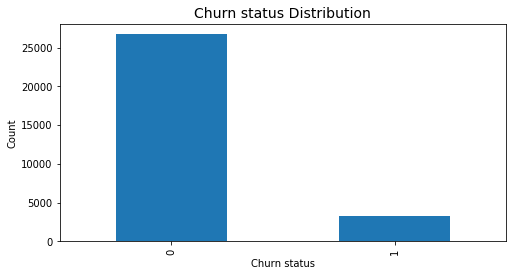

In [74]:
plt.figure(figsize=(8,4))
df['churn_flag'].value_counts().plot(kind = 'bar')
plt.ylabel('Count')
plt.xlabel('Churn status')
plt.title('Churn status Distribution',fontsize=14)

<b>mobile_number</b>

In [77]:
df['mobile_number'].value_counts().sort_values(ascending = False).head()

7000883200    1
7000066065    1
7000688705    1
7001669696    1
7001405503    1
Name: mobile_number, dtype: int64


We can infer that the mobile_number is an unique column, means it's repeated multiple times. So we can safely ignore as it's not going to add any value for our analysis

<b>arpu (Average Revenue per user)</b>

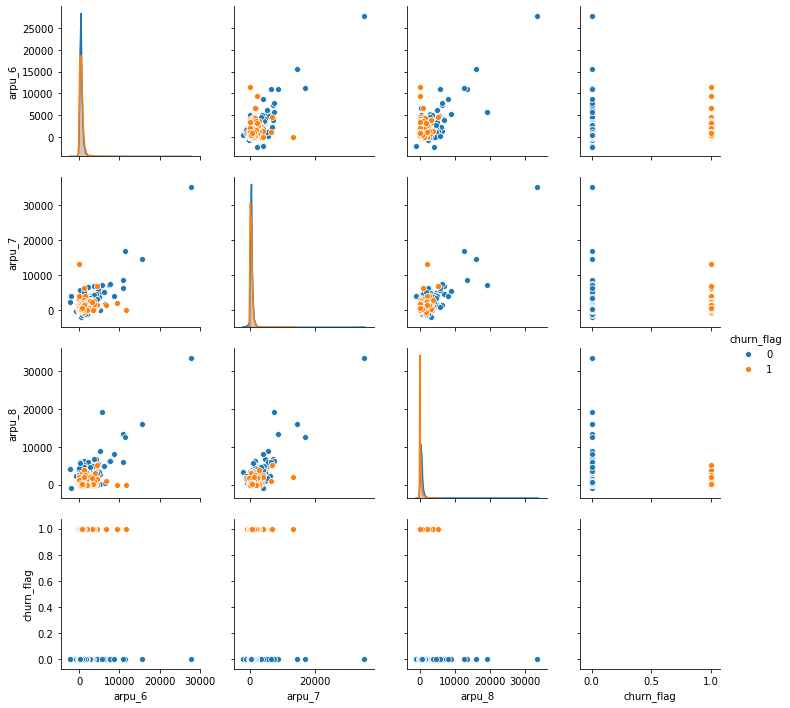

In [79]:
sns.pairplot(data=df[['arpu_6','arpu_7','arpu_8','churn_flag']],hue='churn_flag')

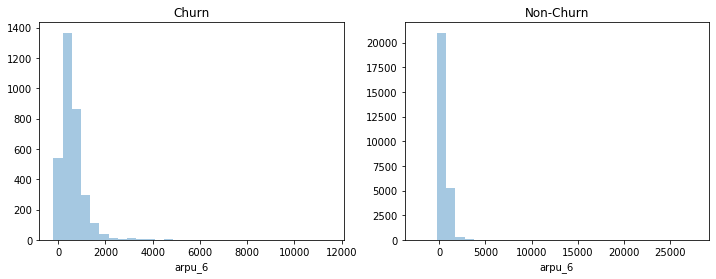

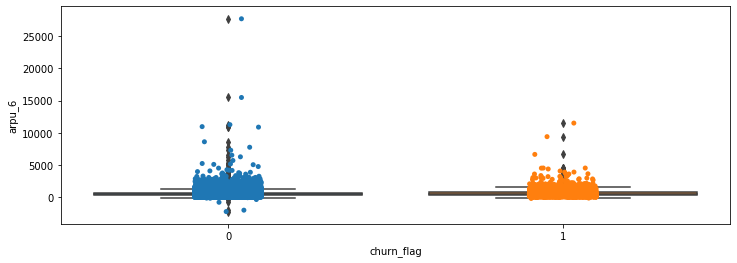

In [80]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].arpu_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].arpu_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='arpu_6', data=df)
sns.stripplot(x='churn_flag', y='arpu_6', data=df, jitter=True, edgecolor="gray")

<b>nnet_mou (On network/ within the same network usage)</b>

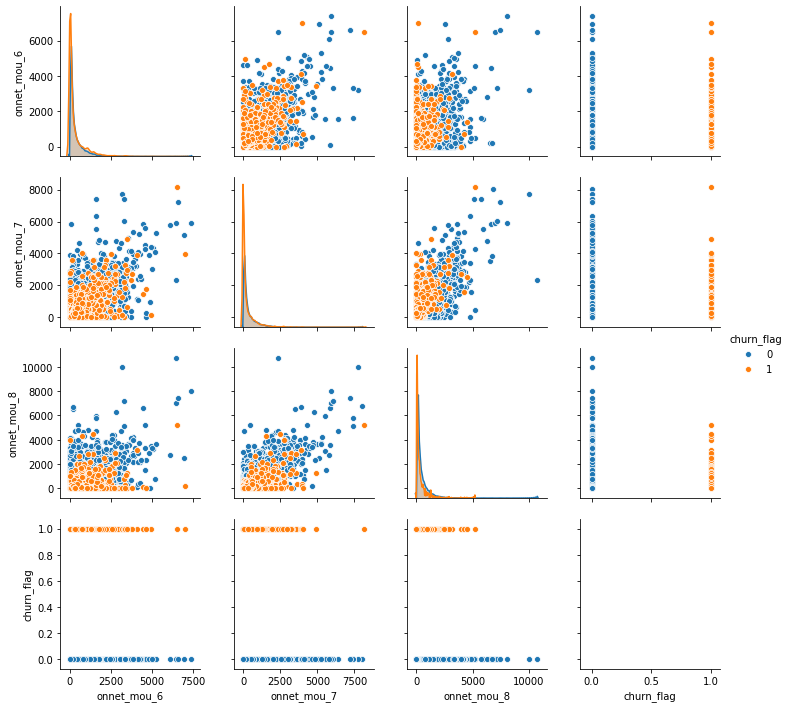

In [81]:
sns.pairplot(data=df[['onnet_mou_6','onnet_mou_7','onnet_mou_8','churn_flag']],hue='churn_flag')

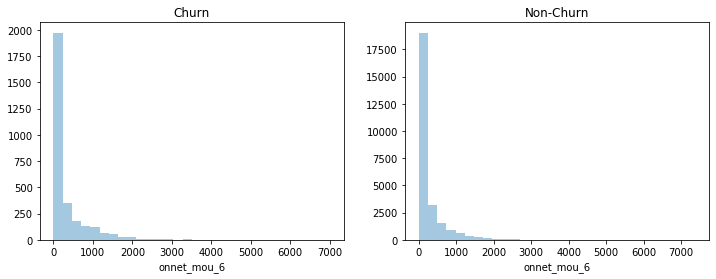

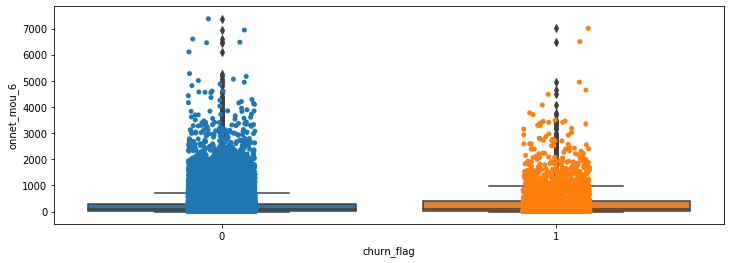

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].onnet_mou_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].onnet_mou_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='onnet_mou_6', data=df)
sns.stripplot(x='churn_flag', y='onnet_mou_6', data=df, jitter=True, edgecolor="gray")

<b>Offnet_mou (Calls outside of the operator network)</b>

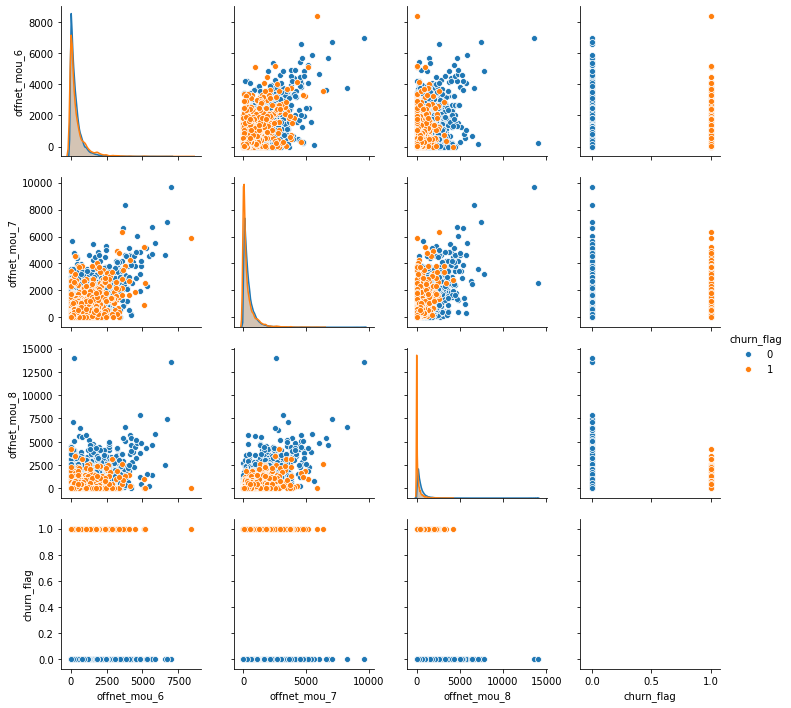

In [83]:
sns.pairplot(data=df[['offnet_mou_6','offnet_mou_7','offnet_mou_8','churn_flag']],hue='churn_flag')

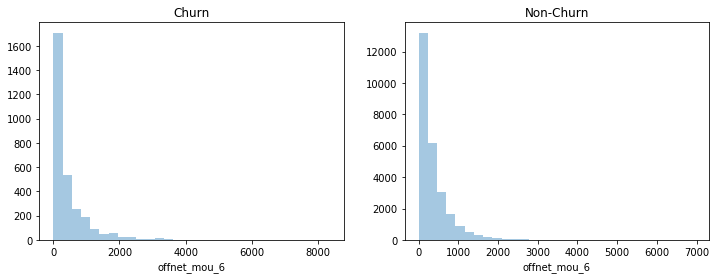

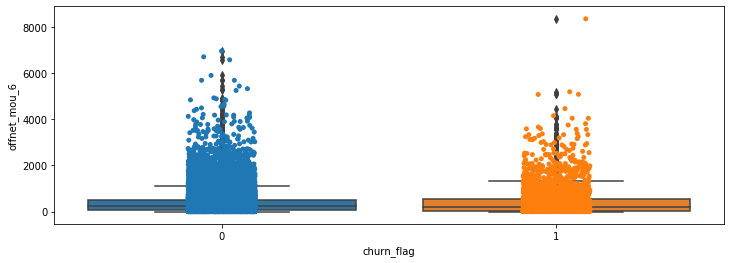

In [84]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].offnet_mou_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].offnet_mou_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='offnet_mou_6', data=df)
sns.stripplot(x='churn_flag', y='offnet_mou_6', data=df, jitter=True, edgecolor="gray")

<b>roam_ic_mou (Customer in roaming zone)</b>

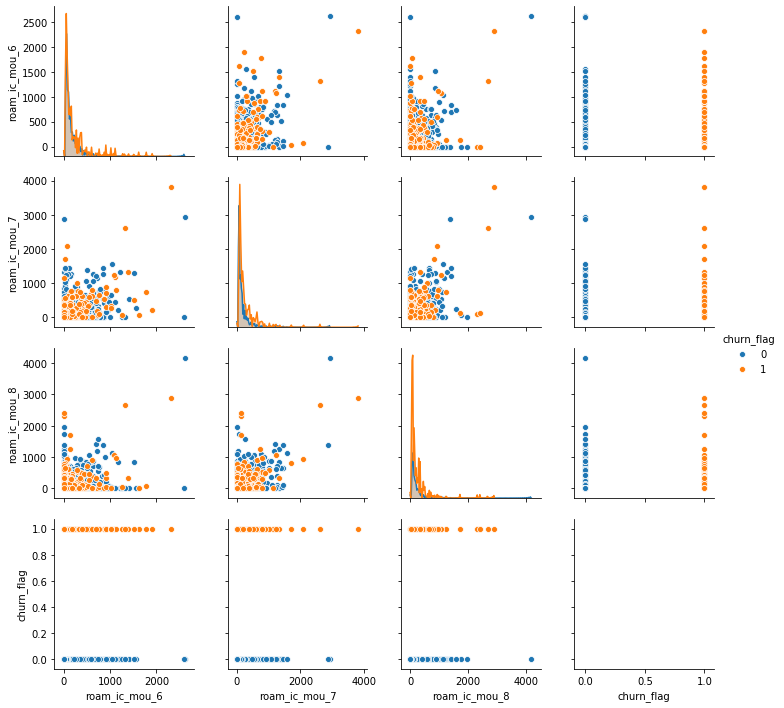

In [85]:
sns.pairplot(data=df[['roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8','churn_flag']],hue='churn_flag')

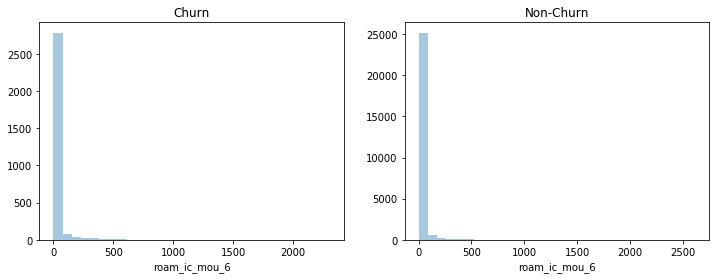

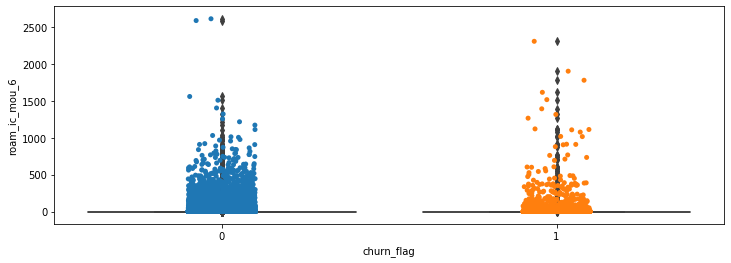

In [86]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].roam_ic_mou_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].roam_ic_mou_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='roam_ic_mou_6', data=df)
sns.stripplot(x='churn_flag', y='roam_ic_mou_6', data=df, jitter=True, edgecolor="gray")

<b>loc_og_mou (within the circle outgoing calls)</b>

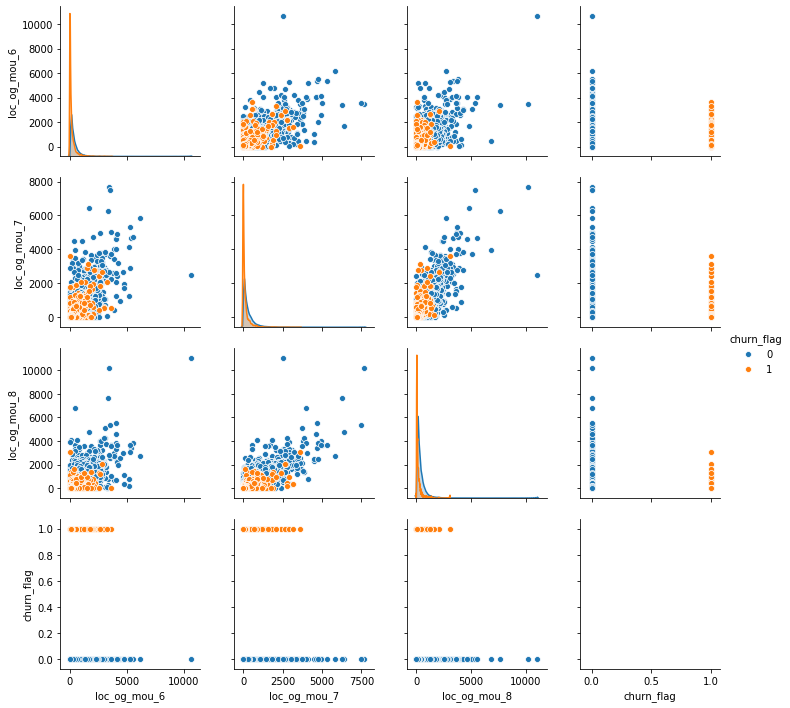

In [87]:
sns.pairplot(data=df[['loc_og_mou_6','loc_og_mou_7','loc_og_mou_8','churn_flag']],hue='churn_flag')

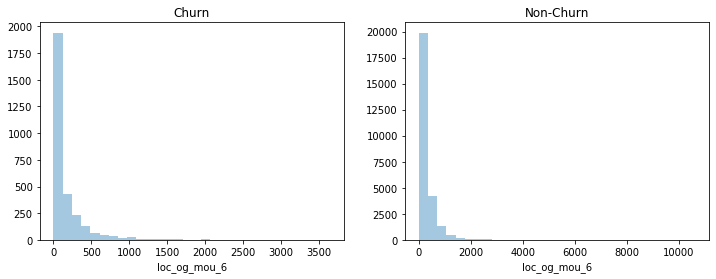

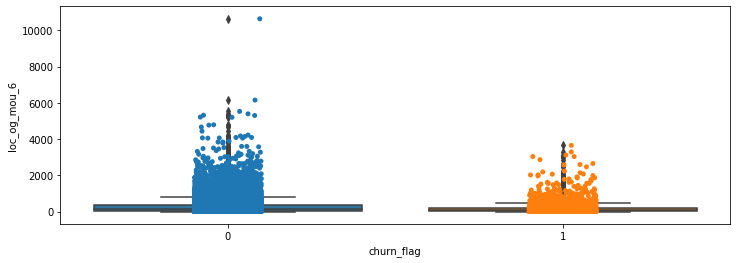

In [88]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].loc_og_mou_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].loc_og_mou_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='loc_og_mou_6', data=df)
sns.stripplot(x='churn_flag', y='loc_og_mou_6', data=df, jitter=True, edgecolor="gray")

<b>std_og_mou (Outside calling circle/zone calls)</b>

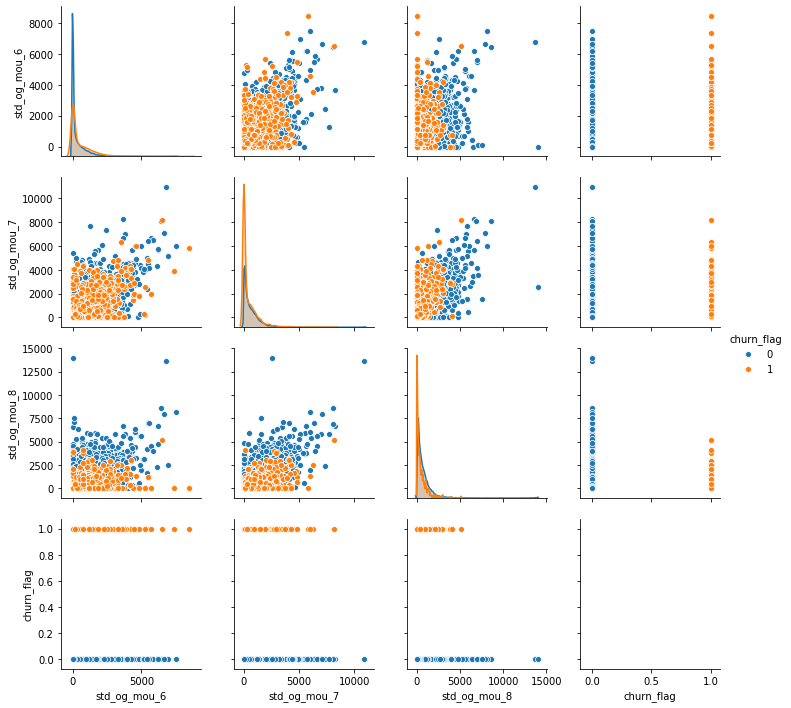

In [90]:
sns.pairplot(data=df[['std_og_mou_6','std_og_mou_7','std_og_mou_8','churn_flag']],hue='churn_flag')

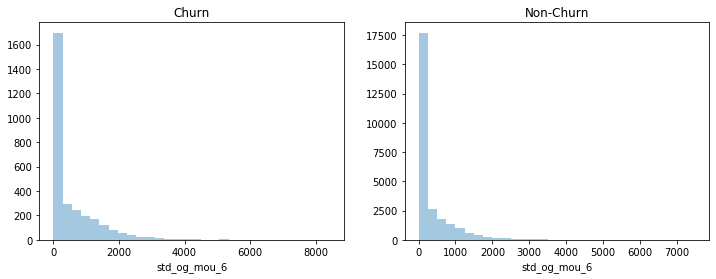

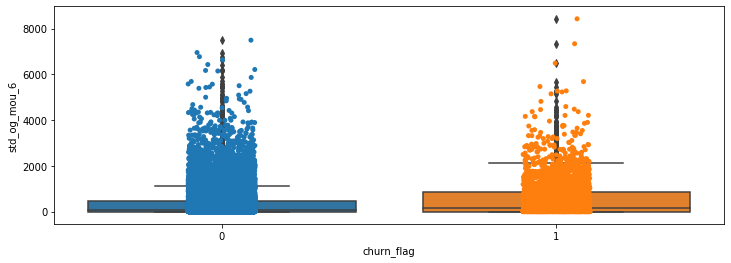

In [91]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].std_og_mou_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].std_og_mou_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='std_og_mou_6', data=df)
sns.stripplot(x='churn_flag', y='std_og_mou_6', data=df, jitter=True, edgecolor="gray")

<b>isd_og (international calling)</b>

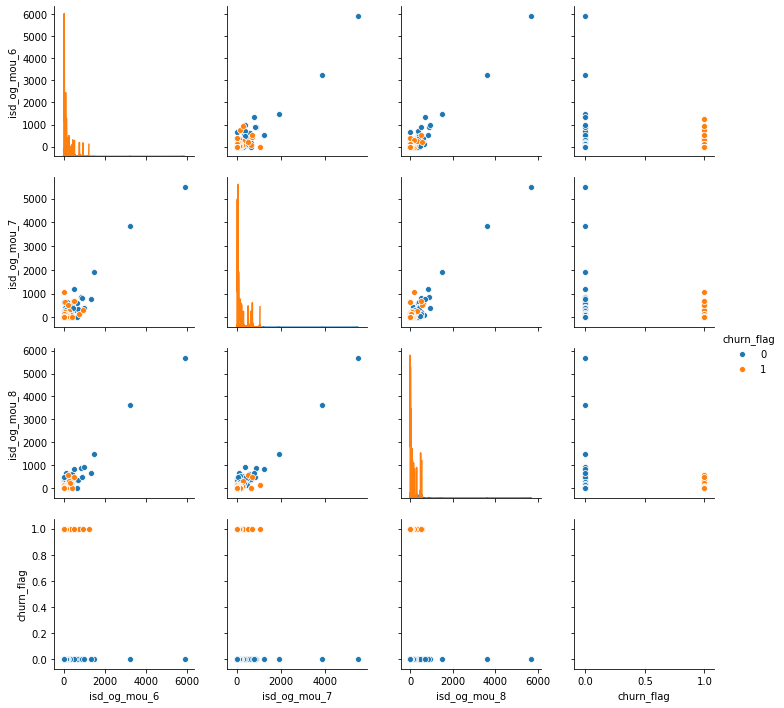

In [93]:
sns.pairplot(data=df[['isd_og_mou_6','isd_og_mou_7','isd_og_mou_8','churn_flag']],hue='churn_flag')

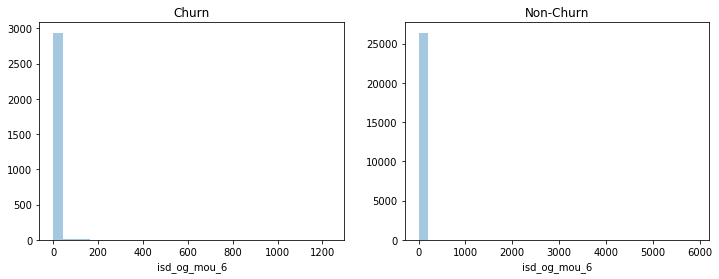

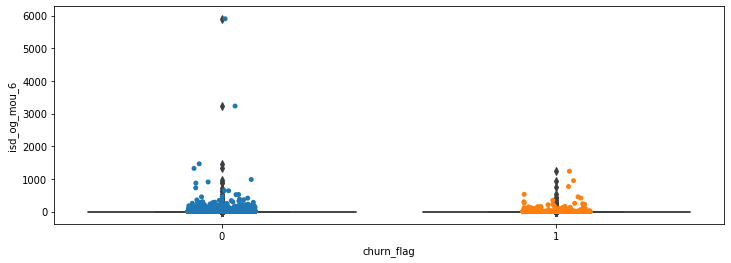

In [94]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].isd_og_mou_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].isd_og_mou_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='isd_og_mou_6', data=df)
sns.stripplot(x='churn_flag', y='isd_og_mou_6', data=df, jitter=True, edgecolor="gray")

<b>totalog (All outgoing calls by the customer)</b>

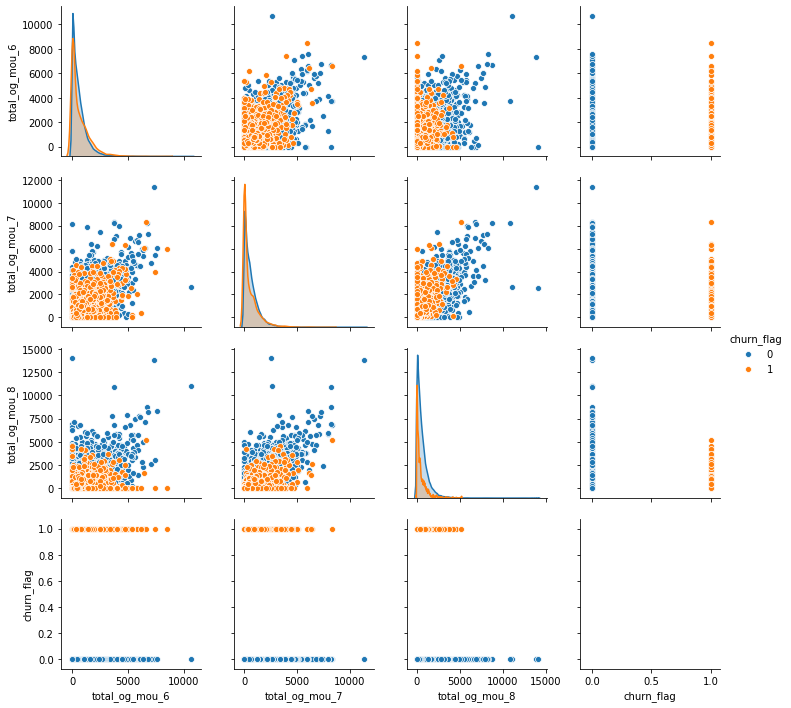

In [95]:
sns.pairplot(data=df[['total_og_mou_6','total_og_mou_7','total_og_mou_8','churn_flag']],hue='churn_flag')

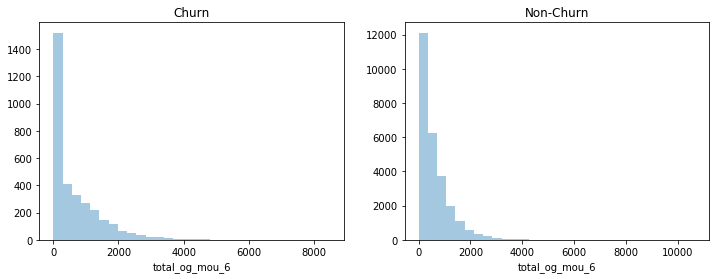

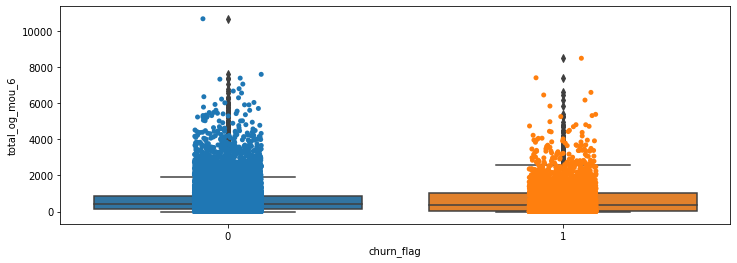

In [96]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].total_og_mou_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].total_og_mou_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='total_og_mou_6', data=df)
sns.stripplot(x='churn_flag', y='total_og_mou_6', data=df, jitter=True, edgecolor="gray")

<b>locic (incoming local calls)</b>

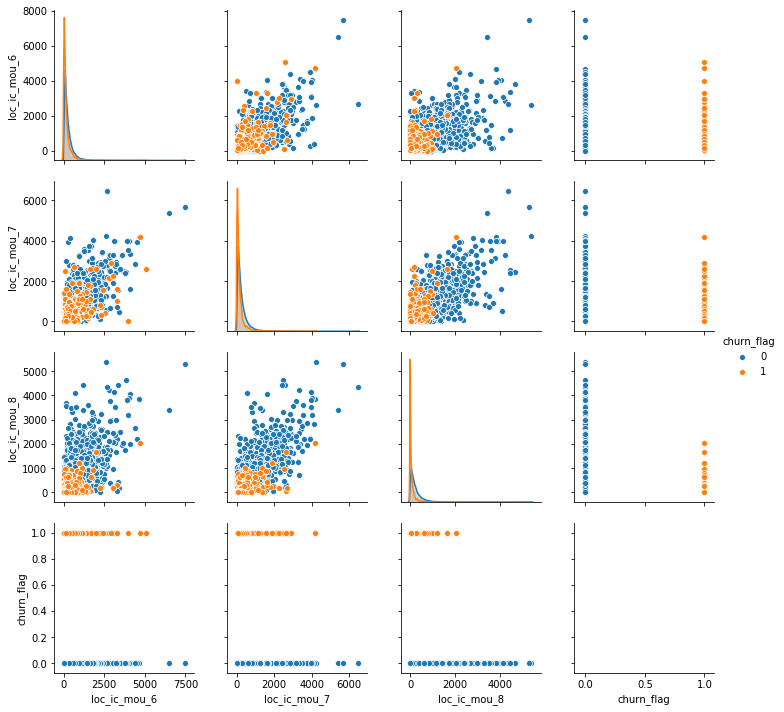

In [97]:
sns.pairplot(data=df[['loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8','churn_flag']],hue='churn_flag')

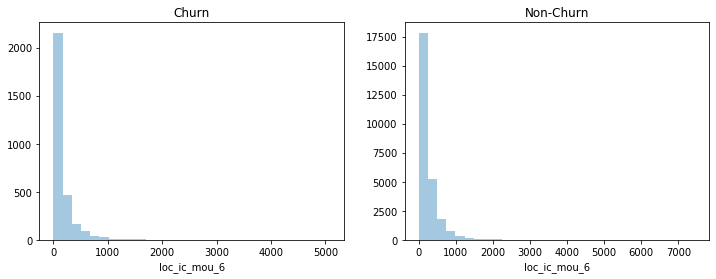

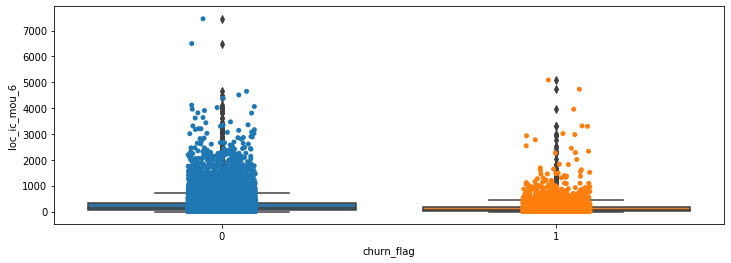

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].loc_ic_mou_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].loc_ic_mou_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='loc_ic_mou_6', data=df)
sns.stripplot(x='churn_flag', y='loc_ic_mou_6', data=df, jitter=True, edgecolor="gray")

<b>stdic (Outside circle incoming calls)</b>

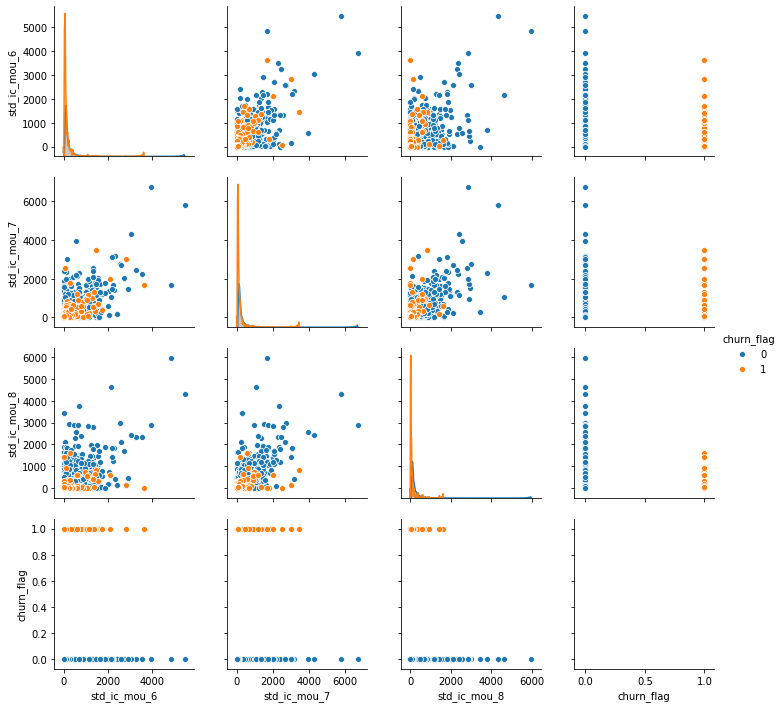

In [100]:
sns.pairplot(data=df[['std_ic_mou_6','std_ic_mou_7','std_ic_mou_8','churn_flag']],hue='churn_flag')

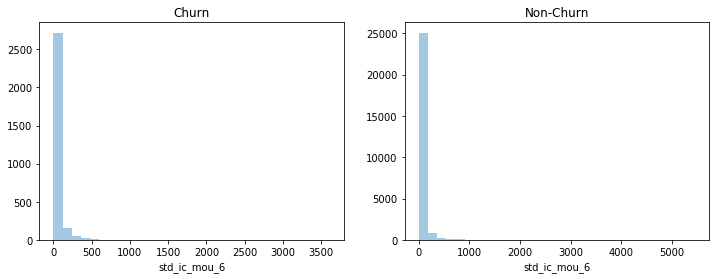

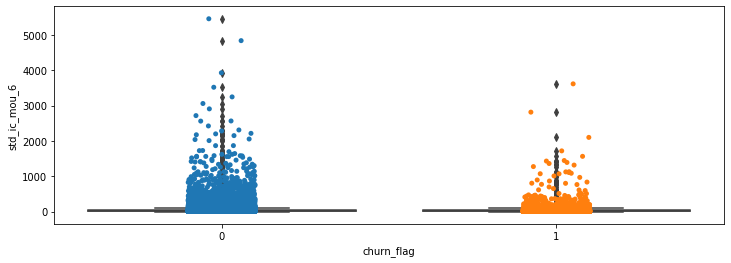

In [101]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].std_ic_mou_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].std_ic_mou_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='std_ic_mou_6', data=df)
sns.stripplot(x='churn_flag', y='std_ic_mou_6', data=df, jitter=True, edgecolor="gray")

<b>totalic (All incoming calls received by a person)</b>

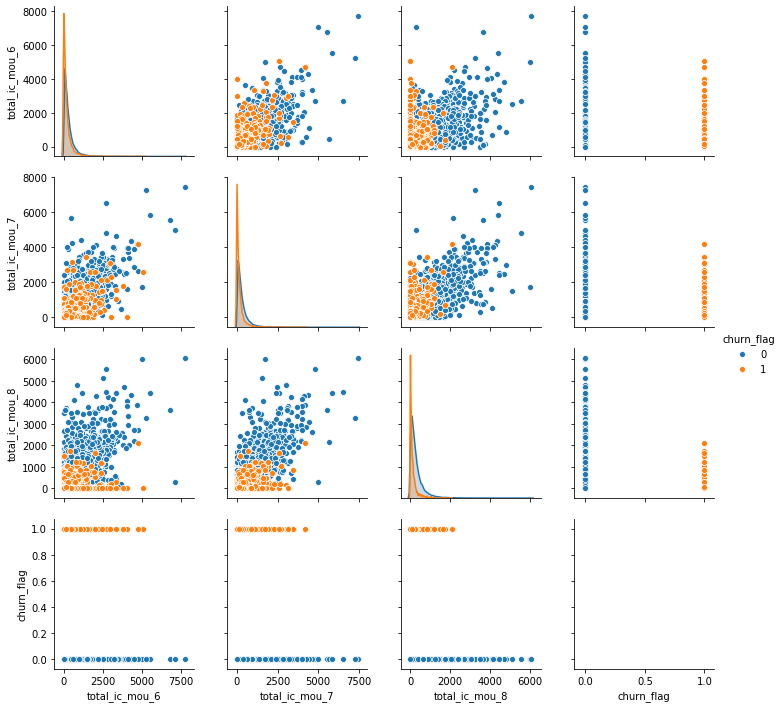

In [102]:
sns.pairplot(data=df[['total_ic_mou_6','total_ic_mou_7','total_ic_mou_8','churn_flag']],hue='churn_flag')

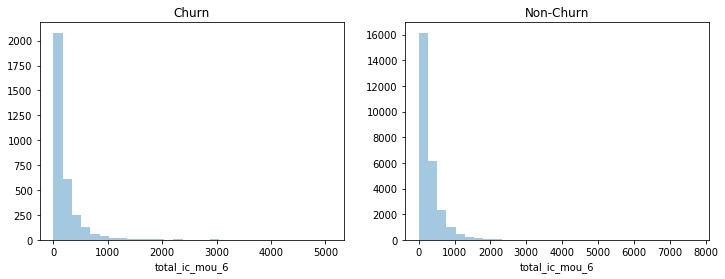

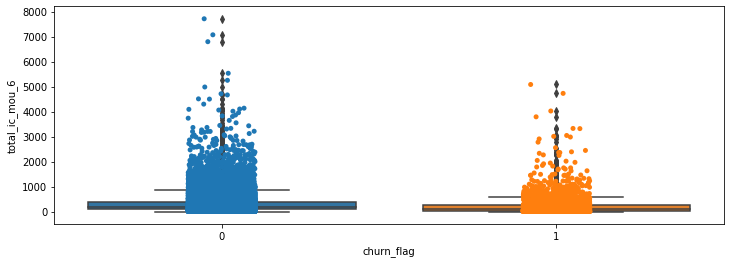

In [103]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].total_ic_mou_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].total_ic_mou_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='total_ic_mou_6', data=df)
sns.stripplot(x='churn_flag', y='total_ic_mou_6', data=df, jitter=True, edgecolor="gray")

<b>total_rech_num (Number of times a subscriber recharged his mobile)</b>

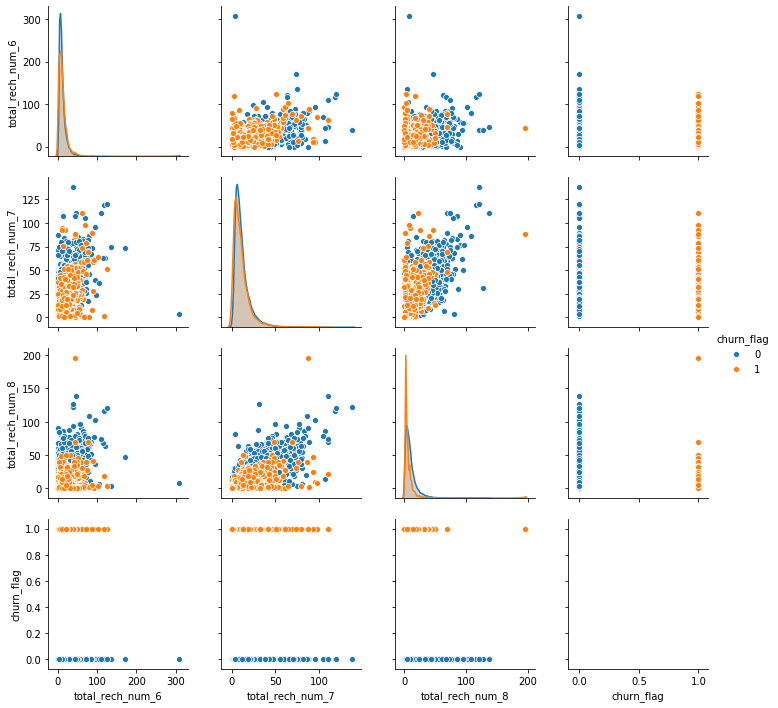

In [104]:
sns.pairplot(data=df[['total_rech_num_6','total_rech_num_7','total_rech_num_8','churn_flag']],hue='churn_flag')

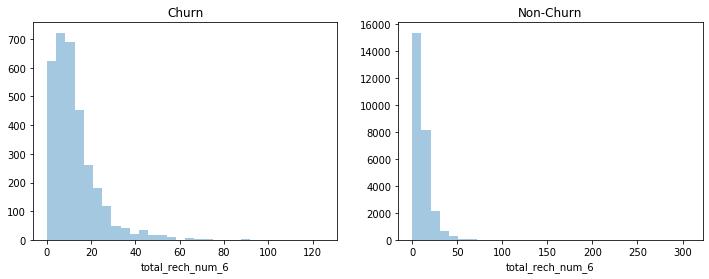

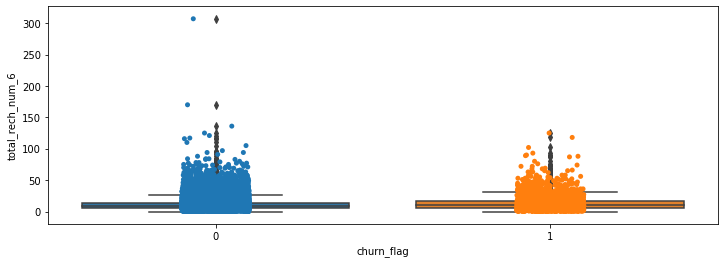

In [105]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].total_rech_num_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].total_rech_num_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='total_rech_num_6', data=df)
sns.stripplot(x='churn_flag', y='total_rech_num_6', data=df, jitter=True, edgecolor="gray")

<b>total_rech_amt
(Total recharge amount in a particular month)</b>

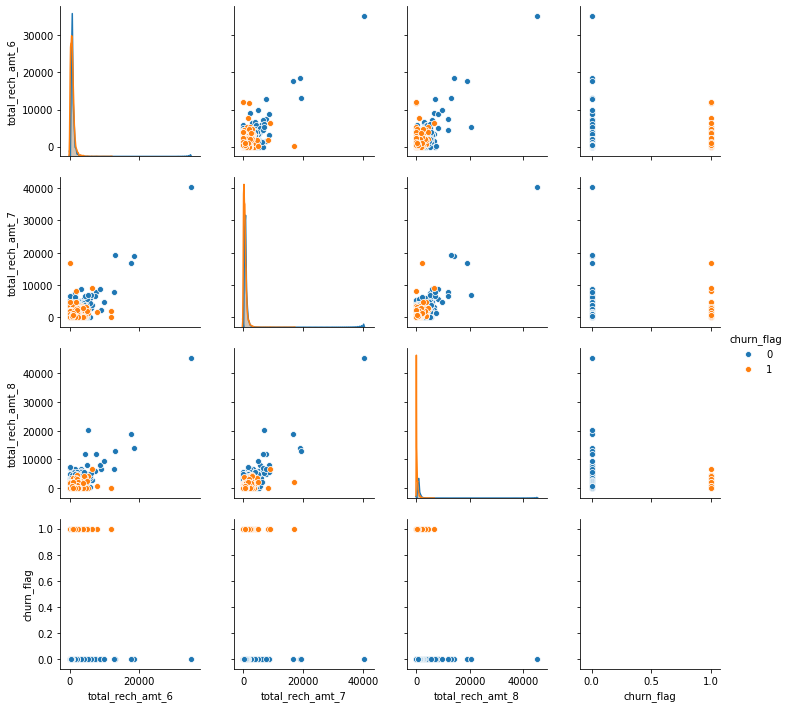

In [107]:
sns.pairplot(data=df[['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','churn_flag']],hue='churn_flag')

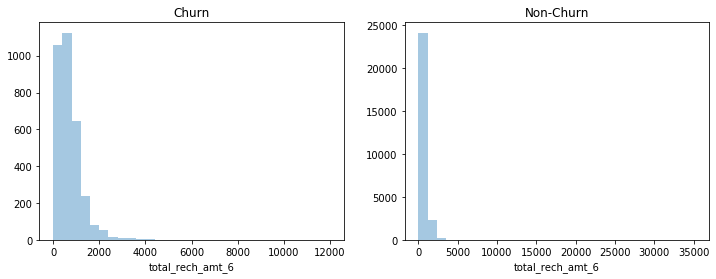

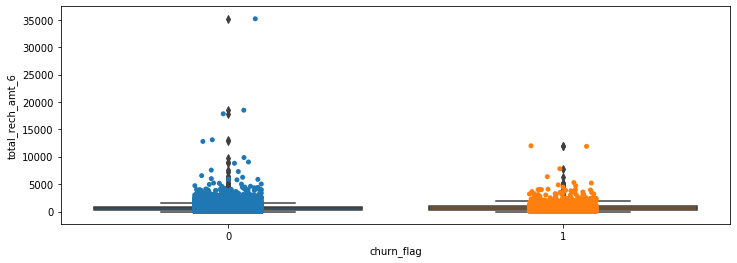

In [108]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].total_rech_amt_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].total_rech_amt_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='total_rech_amt_6', data=df)
sns.stripplot(x='churn_flag', y='total_rech_amt_6', data=df, jitter=True, edgecolor="gray")

<b>total_rech_data
(Total number of times mobile data has been recharged)</b>

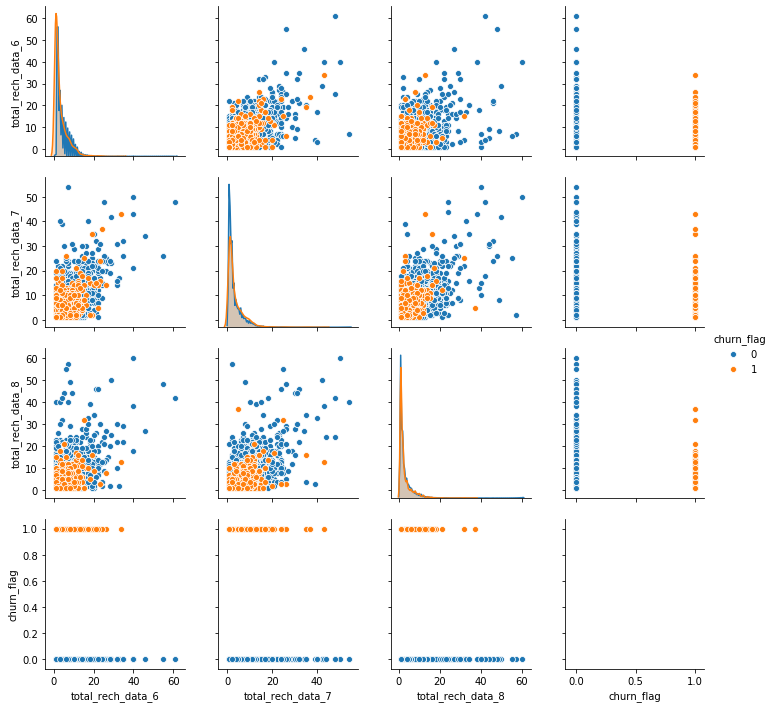

In [110]:
sns.pairplot(data=df[['total_rech_data_6','total_rech_data_7','total_rech_data_8','churn_flag']],hue='churn_flag')

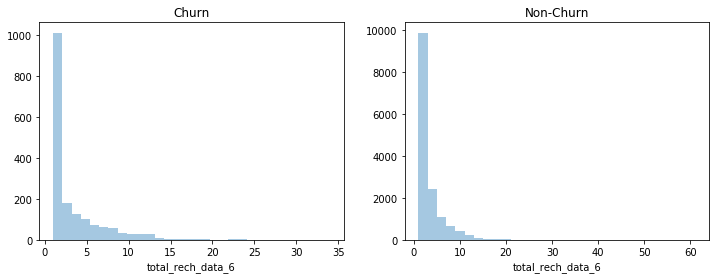

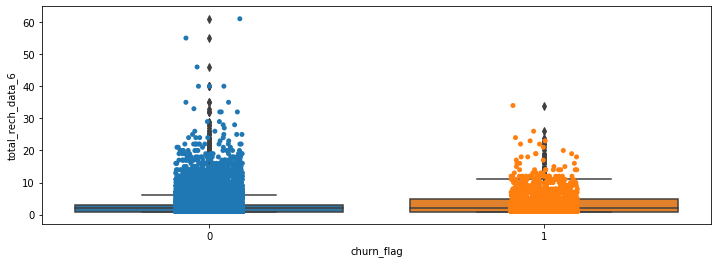

In [111]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].total_rech_data_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].total_rech_data_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='total_rech_data_6', data=df)
sns.stripplot(x='churn_flag', y='total_rech_data_6', data=df, jitter=True, edgecolor="gray")

<b>vol_2g_mb(
Internet usage in MB)</b>

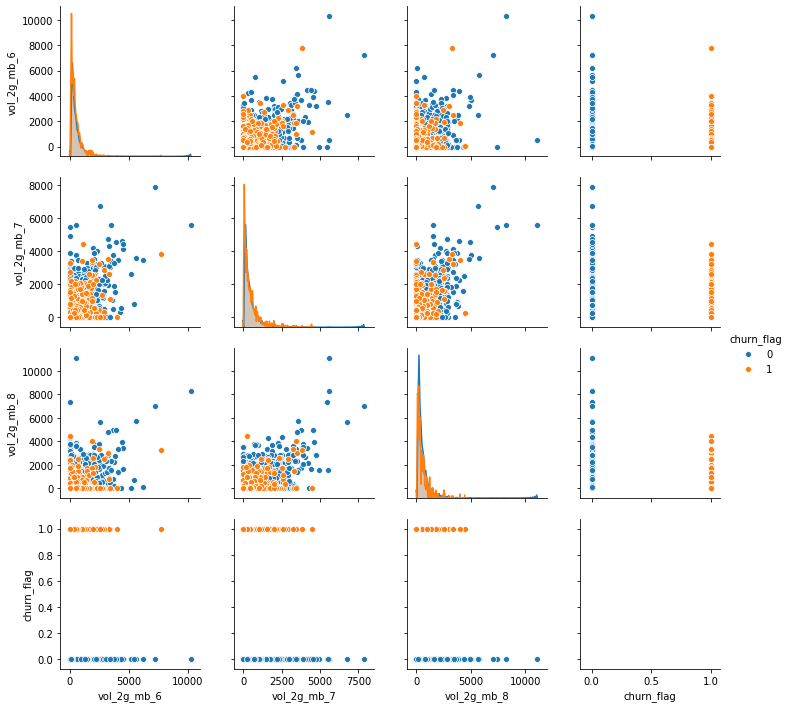

In [113]:
sns.pairplot(data=df[['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','churn_flag']],hue='churn_flag')

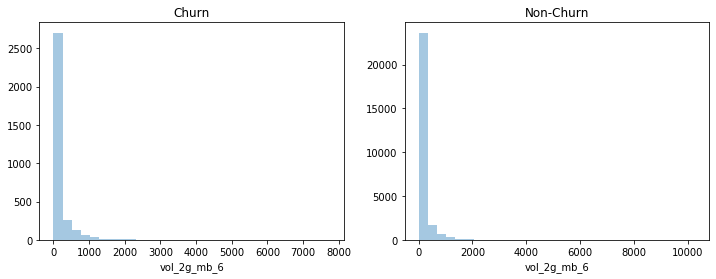

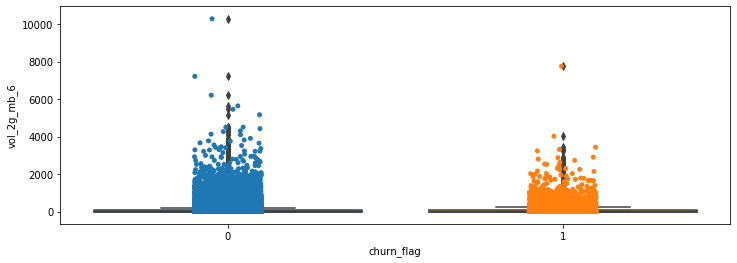

In [114]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].vol_2g_mb_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].vol_2g_mb_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='vol_2g_mb_6', data=df)
sns.stripplot(x='churn_flag', y='vol_2g_mb_6', data=df, jitter=True, edgecolor="gray")

<b>vol_3g_mb
(Internet usage in MB)</b>

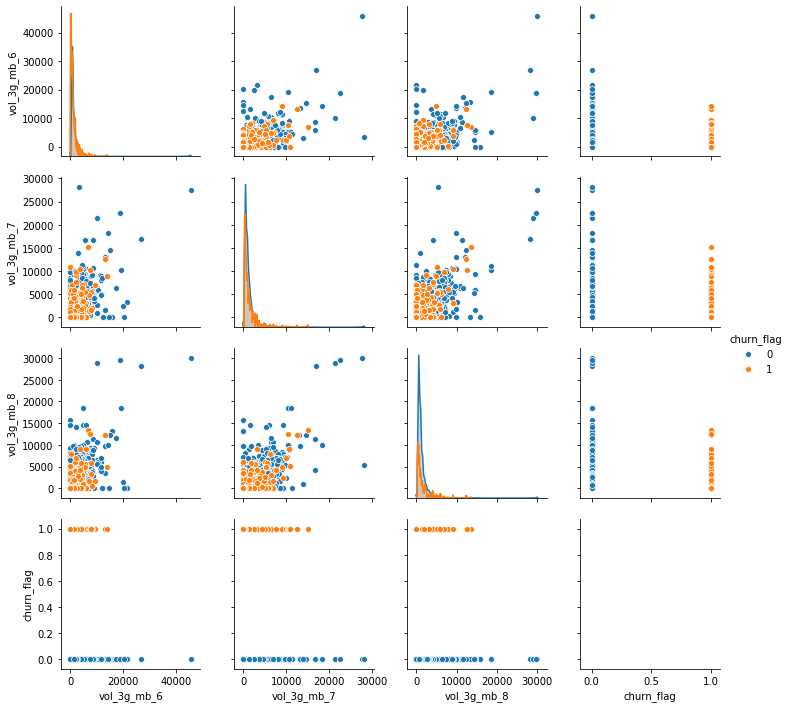

In [116]:
sns.pairplot(data=df[['vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8','churn_flag']],hue='churn_flag')

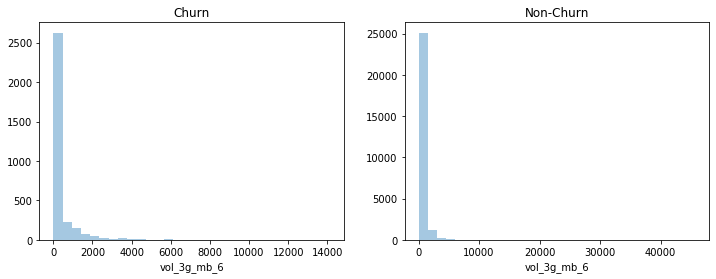

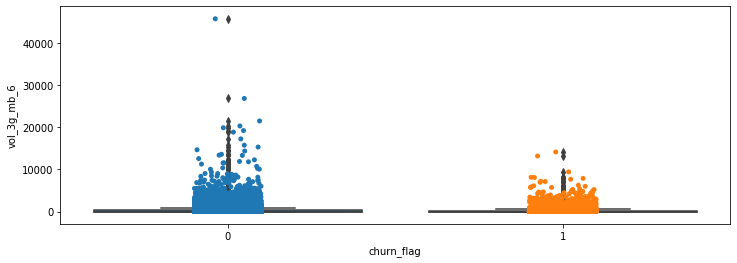

In [118]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].vol_3g_mb_6, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].vol_3g_mb_6, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='vol_3g_mb_6', data=df)
sns.stripplot(x='churn_flag', y='vol_3g_mb_6', data=df, jitter=True, edgecolor="gray")

<b>vbc_3g(
Volume based cost - paid as per usage)</b>

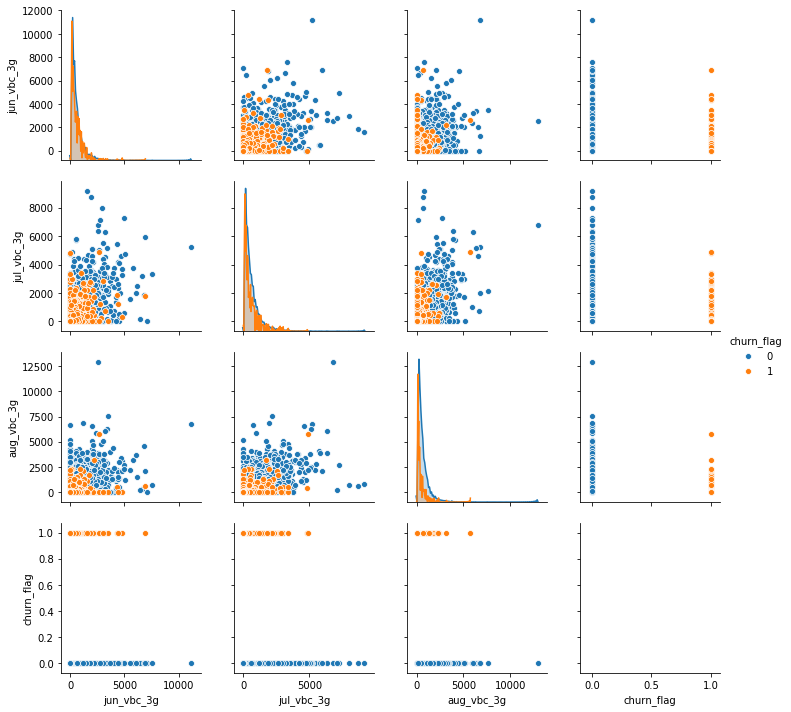

In [120]:
sns.pairplot(data=df[['jun_vbc_3g','jul_vbc_3g','aug_vbc_3g','churn_flag']],hue='churn_flag')

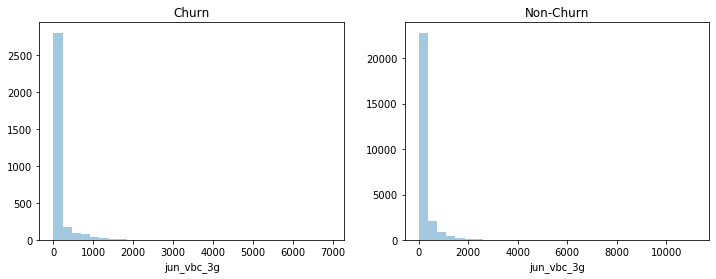

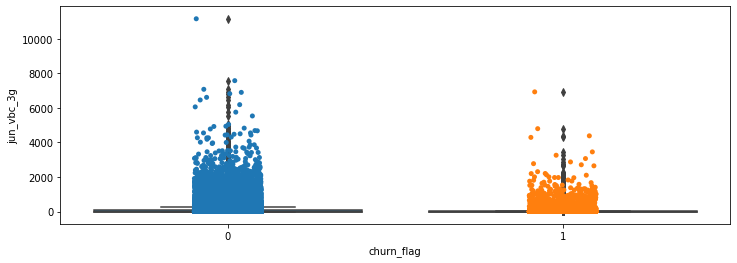

In [121]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
ax = sns.distplot(df[df['churn_flag']==1].jun_vbc_3g, bins = 30, ax = axes[0], kde = False)
ax.set_title('Churn')
ax = sns.distplot(df[df['churn_flag']==0].jun_vbc_3g, bins = 30, ax = axes[1], kde = False)
ax.set_title('Non-Churn')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
sns.boxplot(x='churn_flag', y='jun_vbc_3g', data=df)
sns.stripplot(x='churn_flag', y='jun_vbc_3g', data=df, jitter=True, edgecolor="gray")

We can see few observations across the features, which have a different behavior. Can we consider them as outliers? Nearly 2% to 10% are tagged as outliers based on the feature. If we check the pattern between churn vs non-churn it's same across them and also it's same across the features as well. Therefore we can't exclude them from the model point of view.

<ol><b>Derive new features</b></ol>

First format a date features:

In [122]:
df['date_of_last_rech_6'] = pd.to_datetime(df['date_of_last_rech_6'])
df['date_of_last_rech_7'] = pd.to_datetime(df['date_of_last_rech_7'])
df['date_of_last_rech_8'] = pd.to_datetime(df['date_of_last_rech_8'])

df['date_of_last_rech_data_6'] = pd.to_datetime(df['date_of_last_rech_data_6'])
df['date_of_last_rech_data_7'] = pd.to_datetime(df['date_of_last_rech_data_7'])
df['date_of_last_rech_data_8'] = pd.to_datetime(df['date_of_last_rech_data_8'])

df['mobile_number'] = df['mobile_number'].astype(str)

Create new features from the date columns
This may help us identifying if a particular day in a month or a week causing any issue

In [123]:
# Now let's create new features from date column
df['date_of_last_rech_day_6'] = df['date_of_last_rech_6'].dt.day
df['date_of_last_rech_dayofwk_6'] = df['date_of_last_rech_6'].dt.dayofweek.astype(str)

df['date_of_last_rech_day_7'] = df['date_of_last_rech_7'].dt.day
df['date_of_last_rech_dayofwk_7'] = df['date_of_last_rech_7'].dt.dayofweek.astype(str)

df['date_of_last_rech_day_8'] = df['date_of_last_rech_8'].dt.day
df['date_of_last_rech_dayofwk_8'] = df['date_of_last_rech_8'].dt.dayofweek.astype(str)

df['date_of_last_rech_data_day_6'] = df['date_of_last_rech_data_6'].dt.day
df['date_of_last_rech_data_dayofwk_6'] = df['date_of_last_rech_data_6'].dt.dayofweek.astype(str)

df['date_of_last_rech_data_day_7'] = df['date_of_last_rech_data_7'].dt.day
df['date_of_last_rech_data_dayofwk_7'] = df['date_of_last_rech_data_7'].dt.dayofweek.astype(str)

df['date_of_last_rech_data_day_8'] = df['date_of_last_rech_data_8'].dt.day
df['date_of_last_rech_data_dayofwk_8'] = df['date_of_last_rech_data_8'].dt.dayofweek.astype(str)

In [124]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29953 entries, 0 to 99997
Data columns (total 176 columns):
mobile_number                       29953 non-null object
arpu_6                              29953 non-null float64
arpu_7                              29953 non-null float64
arpu_8                              29953 non-null float64
onnet_mou_6                         29411 non-null float64
onnet_mou_7                         29417 non-null float64
onnet_mou_8                         28781 non-null float64
offnet_mou_6                        29411 non-null float64
offnet_mou_7                        29417 non-null float64
offnet_mou_8                        28781 non-null float64
roam_ic_mou_6                       29411 non-null float64
roam_ic_mou_7                       29417 non-null float64
roam_ic_mou_8                       28781 non-null float64
roam_og_mou_6                       29411 non-null float64
roam_og_mou_7                       29417 non-null float64
roam_o

In [125]:
pd.options.display.float_format = '{:.2f}'.format
df.describe()

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
count 29953.00 29953.00 29953.00     29411.00     29417.00     28781.00   
mean    558.82   561.16   508.89       265.71       272.94       243.89   
std     460.87   480.03   502.14       462.69       483.28       465.51   
min   -2258.71 -2014.05  -945.81         0.00         0.00         0.00   
25%     310.14   310.07   231.62        19.25        18.18        14.28   
50%     482.35   481.50   427.60        88.14        86.89        72.99   
75%     700.24   698.83   661.75       297.49       298.38       255.31   
max   27731.09 35145.83 33543.62      7376.71      8157.78     10752.56   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  ...  \
count      29411.00      29417.00      28781.00       29411.00  ...   
mean         380.69        385.12        348.77          16.42  ...   
std          484.44        501.02        486.84          77.01  ...   
min            0.00          0.00          0.00           0.00  ...   
25%           78.55         76.18         58.76           0.00  ...   
50%          229.63        227.13        197.69           0.00  ...   
75%          494.75        500.48        455.44           0.00  ...   
max         8362.36       9667.13      14007.34        2613.31  ...   

       amt_data_6  amt_data_7  AVG_amt_data_6_7  churn_flag  \
count    29953.00    29953.00          29953.00    29953.00   
mean      1117.51     1189.89           1153.70        0.11   
std       1567.14     1633.21           1359.53        0.31   
min          0.00        0.00            478.50        0.00   
25%        547.00      551.00            604.00        0.00   
50%        788.00      814.00            800.50        0.00   
75%       1210.00     1270.00           1209.00        0.00   
max     113458.00    56075.00          61236.00        1.00   

       date_of_last_rech_day_6  date_of_last_rech_day_7  \
count                 29880.00                 29855.00   
mean                     26.46                    27.27   
std                       4.67                     4.59   
min                       1.00                     1.00   
25%                      25.00                    26.00   
50%                      28.00                    29.00   
75%                      30.00                    31.00   
max                      30.00                    31.00   

       date_of_last_rech_day_8  date_of_last_rech_data_day_6  \
count                 29371.00                      16740.00   
mean                     26.69                         20.17   
std                       5.27                          8.34   
min                       1.00                          1.00   
25%                      25.00                         14.00   
50%                      28.00                         22.00   
75%                      30.00                         27.00   
max                      31.00                         30.00   

       date_of_last_rech_data_day_7  date_of_last_rech_data_day_8  
count                      17038.00                      15935.00  
mean                          21.07                         20.32  
std                            8.48                          8.66  
min                            1.00                          1.00  
25%                           15.00                         13.00  
50%                           23.00                         22.00  
75%                           28.00                         28.00  
max                           31.00                         31.00  

[8 rows x 163 columns]

Let's check the correlation between features

In [126]:
joincorr= df.corr()
df_corr = joincorr.stack().reset_index().sort_values(by = 0, ascending = False)
df_corr[((df_corr[0] < 1) & (df_corr[0] >= 0.4)) | ((df_corr[0] <= -0.4) & (df_corr[0] > -1))]

level_0          level_1     0
22441      sachet_2g_8  count_rech_2g_8  0.99
18067  count_rech_2g_8      sachet_2g_8  0.99
17903  count_rech_2g_7      sachet_2g_7  0.99
22277      sachet_2g_7  count_rech_2g_7  0.99
22113      sachet_2g_6  count_rech_2g_6  0.98
...                ...              ...   ...
17873  count_rech_2g_7  max_rech_data_7 -0.44
17224  max_rech_data_6  count_rech_2g_7 -0.45
17872  count_rech_2g_7  max_rech_data_6 -0.45
17414  max_rech_data_7      sachet_2g_7 -0.45
22274      sachet_2g_7  max_rech_data_7 -0.45

[1474 rows x 3 columns]

From the above we can notice high correlation between same features and only month differs.
How can we take care of those?
We can eliminate as we will lose information of eith good or action month.
Let's create new features from good month and compare them with action phase

In [127]:
df['AVG_arpu_6_7'] = df[['arpu_6','arpu_7']].mean(axis=1)
df['is_arpu_flag'] = np.where((df['arpu_8'] > df['AVG_arpu_6_7']), 0, 1)

df['AVG_onnet_mou_6_7'] = df[['onnet_mou_6','onnet_mou_7']].mean(axis=1)
df['is_onnet_mou_flag'] = np.where((df['onnet_mou_8'] > df['AVG_onnet_mou_6_7']), 0, 1)

df['AVG_offnet_mou_6_7'] = df[['offnet_mou_6','offnet_mou_7']].mean(axis=1)
df['is_offnet_mou_flag'] = np.where((df['offnet_mou_8'] > df['AVG_offnet_mou_6_7']), 0, 1)

df['AVG_roam_ic_mou_6_7'] = df[['roam_ic_mou_6','roam_ic_mou_7']].mean(axis=1)
df['is_roam_ic_mou_flag'] = np.where((df['roam_ic_mou_8'] > df['AVG_roam_ic_mou_6_7']), 0, 1)

df['AVG_roam_og_mou_6_7'] = df[['roam_og_mou_6','roam_og_mou_7']].mean(axis=1)
df['is_roam_og_mou_flag'] = np.where((df['roam_og_mou_8'] > df['AVG_roam_og_mou_6_7']), 0, 1)

df['AVG_loc_og_t2t_mou_6_7'] = df[['loc_og_t2t_mou_6','loc_og_t2t_mou_7']].mean(axis=1)
df['is_loc_og_t2t_mou_flag'] = np.where((df['loc_og_t2t_mou_8'] > df['AVG_loc_og_t2t_mou_6_7']), 0, 1)

df['AVG_loc_og_t2m_mou_6_7'] = df[['loc_og_t2m_mou_6','loc_og_t2m_mou_7']].mean(axis=1)
df['is_loc_og_t2m_mou_flag'] = np.where((df['loc_og_t2m_mou_8'] > df['AVG_loc_og_t2m_mou_6_7']), 0, 1)

df['AVG_loc_og_t2f_mou_6_7'] = df[['loc_og_t2f_mou_6','loc_og_t2f_mou_7']].mean(axis=1)
df['is_loc_og_t2f_mou_flag'] = np.where((df['loc_og_t2f_mou_8'] > df['AVG_loc_og_t2f_mou_6_7']), 0, 1)

df['AVG_loc_og_t2c_mou_6_7'] = df[['loc_og_t2c_mou_6','loc_og_t2c_mou_7']].mean(axis=1)
df['is_loc_og_t2c_mou_flag'] = np.where((df['loc_og_t2c_mou_8'] > df['AVG_loc_og_t2c_mou_6_7']), 0, 1)

df['AVG_std_og_t2t_mou_6_7'] = df[['std_og_t2t_mou_6','std_og_t2t_mou_7']].mean(axis=1)
df['is_std_og_t2t_mou_flag'] = np.where((df['std_og_t2t_mou_8'] > df['AVG_std_og_t2t_mou_6_7']), 0, 1)

df['AVG_std_og_t2m_mou_6_7'] = df[['std_og_t2m_mou_6','std_og_t2m_mou_7']].mean(axis=1)
df['is_std_og_t2m_mou_flag'] = np.where((df['std_og_t2m_mou_8'] > df['AVG_std_og_t2m_mou_6_7']), 0, 1)

df['AVG_std_og_t2f_mou_6_7'] = df[['std_og_t2f_mou_6','std_og_t2f_mou_7']].mean(axis=1)
df['is_std_og_t2f_mou_flag'] = np.where((df['std_og_t2f_mou_8'] > df['AVG_std_og_t2f_mou_6_7']), 0, 1)

df['AVG_isd_og_mou_6_7'] = df[['isd_og_mou_6','isd_og_mou_7']].mean(axis=1)
df['is_isd_og_mou_flag'] = np.where((df['isd_og_mou_8'] > df['AVG_isd_og_mou_6_7']), 0, 1)

df['AVG_spl_og_mou_6_7'] = df[['spl_og_mou_6','spl_og_mou_7']].mean(axis=1)
df['is_spl_og_mou_flag'] = np.where((df['spl_og_mou_8'] > df['AVG_spl_og_mou_6_7']), 0, 1)

df['AVG_og_others_6_7'] = df[['og_others_6','og_others_7']].mean(axis=1)
df['is_og_others_flag'] = np.where((df['og_others_8'] > df['AVG_og_others_6_7']), 0, 1)


df['AVG_loc_ic_t2t_mou_6_7'] = df[['loc_ic_t2t_mou_6','loc_ic_t2t_mou_7']].mean(axis=1)
df['is_loc_ic_t2t_mou_flag'] = np.where((df['loc_ic_t2t_mou_8'] > df['AVG_loc_ic_t2t_mou_6_7']), 0, 1)

df['AVG_loc_ic_t2m_mou_6_7'] = df[['loc_ic_t2m_mou_6','loc_ic_t2m_mou_7']].mean(axis=1)
df['is_loc_ic_t2m_mou_flag'] = np.where((df['loc_ic_t2m_mou_8'] > df['AVG_loc_ic_t2m_mou_6_7']), 0, 1)

df['AVG_loc_ic_t2f_mou_6_7'] = df[['loc_ic_t2f_mou_6','loc_ic_t2f_mou_7']].mean(axis=1)
df['is_loc_ic_t2f_mou_flag'] = np.where((df['loc_ic_t2f_mou_8'] > df['AVG_loc_ic_t2f_mou_6_7']), 0, 1)

df['AVG_std_ic_t2t_mou_6_7'] = df[['std_ic_t2t_mou_6','std_ic_t2t_mou_7']].mean(axis=1)
df['is_std_ic_t2t_mou_flag'] = np.where((df['std_ic_t2t_mou_8'] > df['AVG_std_ic_t2t_mou_6_7']), 0, 1)

df['AVG_std_ic_t2m_mou_6_7'] = df[['std_ic_t2m_mou_6','std_ic_t2m_mou_7']].mean(axis=1)
df['is_std_ic_t2m_mou_flag'] = np.where((df['std_ic_t2m_mou_8'] > df['AVG_std_ic_t2m_mou_6_7']), 0, 1)

df['AVG_std_ic_t2f_mou_6_7'] = df[['std_ic_t2f_mou_6','std_ic_t2f_mou_7']].mean(axis=1)
df['is_std_ic_t2f_mou_flag'] = np.where((df['std_ic_t2f_mou_8'] > df['AVG_std_ic_t2f_mou_6_7']), 0, 1)

df['AVG_spl_ic_mou_6_7'] = df[['spl_ic_mou_6','spl_ic_mou_7']].mean(axis=1)
df['is_spl_ic_mou_flag'] = np.where((df['spl_ic_mou_8'] > df['AVG_spl_ic_mou_6_7']), 0, 1)

df['AVG_isd_ic_mou_6_7'] = df[['isd_ic_mou_6','isd_ic_mou_7']].mean(axis=1)
df['is_isd_ic_mou_flag'] = np.where((df['isd_ic_mou_8'] > df['AVG_isd_ic_mou_6_7']), 0, 1)

df['AVG_ic_others_6_7'] = df[['ic_others_6','ic_others_7']].mean(axis=1)
df['is_ic_others_flag'] = np.where((df['ic_others_8'] > df['AVG_ic_others_6_7']), 0, 1)

df['AVG_total_rech_amt_6_7'] = df[['total_rech_amt_6','total_rech_amt_7']].mean(axis=1)
df['is_total_rech_amt_flag'] = np.where((df['total_rech_amt_8'] > df['AVG_total_rech_amt_6_7']), 0, 1)

df['AVG_vol_2g_mb_6_7'] = df[['vol_2g_mb_6','vol_2g_mb_7']].mean(axis=1)
df['is_vol_2g_mb_flag'] = np.where((df['vol_2g_mb_8'] > df['AVG_vol_2g_mb_6_7']), 0, 1)

df['AVG_vol_3g_mb_6_7'] = df[['vol_3g_mb_6','vol_3g_mb_7']].mean(axis=1)
df['is_vol_3g_mb_flag'] = np.where((df['vol_3g_mb_8'] > df['AVG_vol_3g_mb_6_7']), 0, 1)

df['AVG_arpu_3g_6_7'] = df[['arpu_3g_6','arpu_3g_7']].mean(axis=1)
df['is_arpu_3g_flag'] = np.where((df['arpu_3g_8'] > df['AVG_arpu_3g_6_7']), 0, 1)

df['AVG_arpu_2g_6_7'] = df[['arpu_2g_6','arpu_2g_7']].mean(axis=1)
df['is_arpu_2g_flag'] = np.where((df['arpu_2g_8'] > df['AVG_arpu_2g_6_7']), 0, 1)

df['AVG_vbc_3g_6_7'] = df[['jun_vbc_3g','jul_vbc_3g']].mean(axis=1)
df['is_vbc_3g_flag'] = np.where((df['aug_vbc_3g'] > df['AVG_vbc_3g_6_7']), 0, 1)

df['AVG_loc_og_mou_6_7'] = df[['loc_og_mou_6','loc_og_mou_7']].mean(axis=1)
df['is_loc_og_mou_flag'] = np.where((df['loc_og_mou_8'] > df['AVG_loc_og_mou_6_7']), 0, 1)

df['AVG_std_og_mou_6_7'] = df[['std_og_mou_6','std_og_mou_7']].mean(axis=1)
df['is_std_og_mou_flag'] = np.where((df['std_og_mou_8'] > df['AVG_std_og_mou_6_7']), 0, 1)

df['AVG_total_og_mou_6_7'] = df[['total_og_mou_6','total_og_mou_7']].mean(axis=1)
df['is_total_og_mou_flag'] = np.where((df['total_og_mou_8'] > df['AVG_total_og_mou_6_7']), 0, 1)

df['AVG_loc_ic_mou_6_7'] = df[['loc_ic_mou_6','loc_ic_mou_7']].mean(axis=1)
df['is_loc_ic_mou_flag'] = np.where((df['loc_ic_mou_8'] > df['AVG_loc_ic_mou_6_7']), 0, 1)

df['AVG_std_ic_mou_6_7'] = df[['std_ic_mou_6','std_ic_mou_7']].mean(axis=1)
df['is_std_ic_mou_flag'] = np.where((df['std_ic_mou_8'] > df['AVG_std_ic_mou_6_7']), 0, 1)

df['AVG_total_ic_mou_6_7'] = df[['total_ic_mou_6','total_ic_mou_7']].mean(axis=1)
df['is_total_ic_mou_flag'] = np.where((df['total_ic_mou_8'] > df['AVG_total_ic_mou_6_7']), 0, 1)

df['AVG_night_pck_user_6_7'] = df[['night_pck_user_6','night_pck_user_7']].mean(axis=1)
df['is_night_pck_user_flag'] = np.where((df['night_pck_user_8'] > df['AVG_night_pck_user_6_7']), 0, 1)

df['AVG_monthly_2g_6_7'] = df[['monthly_2g_6','monthly_2g_7']].mean(axis=1)
df['is_monthly_2g_flag'] = np.where((df['monthly_2g_8'] > df['AVG_monthly_2g_6_7']), 0, 1)

df['AVG_sachet_2g_6_7'] = df[['sachet_2g_6','sachet_2g_7']].mean(axis=1)
df['is_sachet_2g_flag'] = np.where((df['sachet_2g_8'] > df['AVG_sachet_2g_6_7']), 0, 1)

df['AVG_monthly_3g_6_7'] = df[['monthly_3g_6','monthly_3g_7']].mean(axis=1)
df['is_monthly_3g_flag'] = np.where((df['monthly_3g_8'] > df['AVG_monthly_3g_6_7']), 0, 1)

df['AVG_sachet_3g_6_7'] = df[['sachet_3g_6','sachet_3g_7']].mean(axis=1)
df['is_sachet_3g_flag'] = np.where((df['sachet_3g_8'] > df['AVG_sachet_3g_6_7']), 0, 1)

df['AVG_fb_user_6_7'] = df[['fb_user_6','fb_user_7']].mean(axis=1)
df['is_fb_user_flag'] = np.where((df['fb_user_8'] > df['AVG_fb_user_6_7']), 0, 1)

Create month on month change features to undersatnd any risk associated with it

In [128]:
df['loc_og_t2t_mou_7diff6'] = df['loc_og_t2t_mou_7'] - df['loc_og_t2t_mou_6']
df['loc_og_t2m_mou_7diff6'] = df['loc_og_t2m_mou_7'] - df['loc_og_t2m_mou_6']
df['loc_og_t2f_mou_7diff6'] = df['loc_og_t2f_mou_7'] - df['loc_og_t2f_mou_6']
df['loc_og_t2c_mou_7diff6'] = df['loc_og_t2c_mou_7'] - df['loc_og_t2c_mou_6']
df['loc_og_mou_7diff6'] = df['loc_og_mou_7'] - df['loc_og_mou_6']
df['std_og_t2t_mou_7diff6'] = df['std_og_t2t_mou_7'] - df['std_og_t2t_mou_6']
df['std_og_t2m_mou_7diff6'] = df['std_og_t2m_mou_7'] - df['std_og_t2m_mou_6']
df['std_og_t2f_mou_7diff6'] = df['std_og_t2f_mou_7'] - df['std_og_t2f_mou_6']
df['std_og_mou_7diff6'] = df['std_og_mou_7'] - df['std_og_mou_6']
df['loc_og_mou_7diff6'] = df['loc_og_mou_7'] - df['loc_og_mou_6']
df['std_og_mou_7diff6'] = df['std_og_mou_7'] - df['std_og_mou_6']
df['isd_og_mou_7diff6'] = df['isd_og_mou_7'] - df['isd_og_mou_6']
df['spl_og_mou_7diff6'] = df['spl_og_mou_7'] - df['spl_og_mou_6']
df['og_others_7diff6'] = df['og_others_7'] - df['og_others_6']
df['total_og_mou_7diff6'] = df['total_og_mou_7'] - df['total_og_mou_6']

df['loc_og_t2t_mou_8diff7'] = df['loc_og_t2t_mou_8'] - df['loc_og_t2t_mou_7']
df['loc_og_t2m_mou_8diff7'] = df['loc_og_t2m_mou_8'] - df['loc_og_t2m_mou_7']
df['loc_og_t2f_mou_8diff7'] = df['loc_og_t2f_mou_8'] - df['loc_og_t2f_mou_7']
df['loc_og_t2c_mou_8diff7'] = df['loc_og_t2c_mou_8'] - df['loc_og_t2c_mou_7']
df['loc_og_mou_8diff7'] = df['loc_og_mou_8'] - df['loc_og_mou_7']
df['std_og_t2t_mou_8diff7'] = df['std_og_t2t_mou_8'] - df['std_og_t2t_mou_7']
df['std_og_t2m_mou_8diff7'] = df['std_og_t2m_mou_8'] - df['std_og_t2m_mou_7']
df['std_og_t2f_mou_8diff7'] = df['std_og_t2f_mou_8'] - df['std_og_t2f_mou_7']
df['std_og_mou_8diff7'] = df['std_og_mou_8'] - df['std_og_mou_7']
df['loc_og_mou_8diff7'] = df['loc_og_mou_8'] - df['loc_og_mou_7']
df['std_og_mou_8diff7'] = df['std_og_mou_8'] - df['std_og_mou_7']
df['isd_og_mou_8diff7'] = df['isd_og_mou_8'] - df['isd_og_mou_7']
df['spl_og_mou_8diff7'] = df['spl_og_mou_8'] - df['spl_og_mou_7']
df['og_others_8diff7'] = df['og_others_8'] - df['og_others_7']
df['total_og_mou_8diff7'] = df['total_og_mou_8'] - df['total_og_mou_7']

df['loc_ic_t2t_mou_7diff6'] = df['loc_ic_t2t_mou_7'] - df['loc_ic_t2t_mou_6']
df['loc_ic_t2m_mou_7diff6'] = df['loc_ic_t2m_mou_7'] - df['loc_ic_t2m_mou_6']
df['loc_ic_t2f_mou_7diff6'] = df['loc_ic_t2f_mou_7'] - df['loc_ic_t2f_mou_6']
df['loc_ic_mou_7diff6'] = df['loc_ic_mou_7'] - df['loc_ic_mou_6']
df['std_ic_t2t_mou_7diff6'] = df['std_ic_t2t_mou_7'] - df['std_ic_t2t_mou_6']
df['std_ic_t2m_mou_7diff6'] = df['std_ic_t2m_mou_7'] - df['std_ic_t2m_mou_6']
df['std_ic_t2f_mou_7diff6'] = df['std_ic_t2f_mou_7'] - df['std_ic_t2f_mou_6']
df['std_ic_mou_7diff6'] = df['std_ic_mou_7'] - df['std_ic_mou_6']
df['loc_ic_mou_7diff6'] = df['loc_ic_mou_7'] - df['loc_ic_mou_6']
df['std_ic_mou_7diff6'] = df['std_ic_mou_7'] - df['std_ic_mou_6']
df['spl_ic_mou_7diff6'] = df['spl_ic_mou_7'] - df['spl_ic_mou_6']
df['isd_ic_mou_7diff6'] = df['isd_ic_mou_7'] - df['isd_ic_mou_6']
df['ic_others_7diff6'] = df['ic_others_7'] - df['ic_others_6']
df['total_ic_mou_7diff6'] = df['total_ic_mou_7'] - df['total_ic_mou_6']

df['loc_ic_t2t_mou_8diff7'] = df['loc_ic_t2t_mou_8'] - df['loc_ic_t2t_mou_7']
df['loc_ic_t2m_mou_8diff7'] = df['loc_ic_t2m_mou_8'] - df['loc_ic_t2m_mou_7']
df['loc_ic_t2f_mou_8diff7'] = df['loc_ic_t2f_mou_8'] - df['loc_ic_t2f_mou_7']
df['loc_ic_mou_8diff7'] = df['loc_ic_mou_8'] - df['loc_ic_mou_7']
df['std_ic_t2t_mou_8diff7'] = df['std_ic_t2t_mou_8'] - df['std_ic_t2t_mou_7']
df['std_ic_t2m_mou_8diff7'] = df['std_ic_t2m_mou_8'] - df['std_ic_t2m_mou_7']
df['std_ic_t2f_mou_8diff7'] = df['std_ic_t2f_mou_8'] - df['std_ic_t2f_mou_7']
df['std_ic_mou_8diff7'] = df['std_ic_mou_8'] - df['std_ic_mou_7']
df['loc_ic_mou_8diff7'] = df['loc_ic_mou_8'] - df['loc_ic_mou_7']
df['std_ic_mou_8diff7'] = df['std_ic_mou_8'] - df['std_ic_mou_7']
df['spl_ic_mou_8diff7'] = df['spl_ic_mou_8'] - df['spl_ic_mou_7']
df['isd_ic_mou_8diff7'] = df['isd_ic_mou_8'] - df['isd_ic_mou_7']
df['ic_others_8diff7'] = df['ic_others_8'] - df['ic_others_7']
df['total_ic_mou_8diff7'] = df['total_ic_mou_8'] - df['total_ic_mou_7']

df['onnet_mou_7diff6'] = df['onnet_mou_7'] - df['onnet_mou_6']
df['onnet_mou_8diff7'] = df['onnet_mou_8'] - df['onnet_mou_7']

df['offnet_mou_7diff6'] = df['offnet_mou_7'] - df['offnet_mou_6']
df['offnet_mou_8diff7'] = df['offnet_mou_8'] - df['offnet_mou_7']

df['roam_ic_mou_7diff6'] = df['roam_ic_mou_7'] - df['roam_ic_mou_6']
df['roam_ic_mou_8diff7'] = df['roam_ic_mou_8'] - df['roam_ic_mou_7']

df['roam_og_mou_7diff6'] = df['roam_og_mou_7'] - df['roam_og_mou_6']
df['roam_og_mou_8diff7'] = df['roam_og_mou_8'] - df['roam_og_mou_7']

df['total_rech_amt_7diff6'] = df['total_rech_amt_7'] - df['total_rech_amt_6']
df['total_rech_amt_8diff7'] = df['total_rech_amt_8'] - df['total_rech_amt_7']

df['date_of_last_rech_7diff6'] = (df['date_of_last_rech_7'] - df['date_of_last_rech_6']).dt.days
df['date_of_last_rech_8diff7'] = (df['date_of_last_rech_8'] - df['date_of_last_rech_7']).dt.days

df['date_of_last_rech_data_7diff6'] = (df['date_of_last_rech_data_7'] - df['date_of_last_rech_data_6']).dt.days
df['date_of_last_rech_data_8diff7'] = (df['date_of_last_rech_data_8'] - df['date_of_last_rech_data_7']).dt.days

df['vol_2g_mb_7diff6'] = df['vol_2g_mb_7'] - df['vol_2g_mb_6']
df['vol_2g_mb_8diff7'] = df['vol_2g_mb_8'] - df['vol_2g_mb_7']

df['vol_3g_mb_7diff6'] = df['vol_3g_mb_7'] - df['vol_3g_mb_6']
df['vol_3g_mb_8diff7'] = df['vol_3g_mb_8'] - df['vol_3g_mb_7']

df['vbc_3g_7diff6'] = df['jul_vbc_3g'] - df['jun_vbc_3g']
df['vbc_3g_8diff7'] = df['aug_vbc_3g'] - df['jul_vbc_3g']

In [129]:
df.describe()

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
count 29953.00 29953.00 29953.00     29411.00     29417.00     28781.00   
mean    558.82   561.16   508.89       265.71       272.94       243.89   
std     460.87   480.03   502.14       462.69       483.28       465.51   
min   -2258.71 -2014.05  -945.81         0.00         0.00         0.00   
25%     310.14   310.07   231.62        19.25        18.18        14.28   
50%     482.35   481.50   427.60        88.14        86.89        72.99   
75%     700.24   698.83   661.75       297.49       298.38       255.31   
max   27731.09 35145.83 33543.62      7376.71      8157.78     10752.56   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  ...  \
count      29411.00      29417.00      28781.00       29411.00  ...   
mean         380.69        385.12        348.77          16.42  ...   
std          484.44        501.02        486.84          77.01  ...   
min            0.00          0.00          0.00           0.00  ...   
25%           78.55         76.18         58.76           0.00  ...   
50%          229.63        227.13        197.69           0.00  ...   
75%          494.75        500.48        455.44           0.00  ...   
max         8362.36       9667.13      14007.34        2613.31  ...   

       date_of_last_rech_7diff6  date_of_last_rech_8diff7  \
count                  29782.00                  29328.00   
mean                      30.79                     30.32   
std                        5.60                      5.81   
min                        1.00                      1.00   
25%                       28.00                     28.00   
50%                       31.00                     31.00   
75%                       33.00                     33.00   
max                       60.00                     61.00   

       date_of_last_rech_data_7diff6  date_of_last_rech_data_8diff7  \
count                       14297.00                       13664.00   
mean                           30.83                          29.95   
std                             9.82                           9.85   
min                             1.00                           1.00   
25%                            27.00                          26.00   
50%                            30.00                          29.00   
75%                            35.00                          34.00   
max                            60.00                          61.00   

       vol_2g_mb_7diff6  vol_2g_mb_8diff7  vol_3g_mb_7diff6  vol_3g_mb_8diff7  \
count          29953.00          29953.00          29953.00          29953.00   
mean              -1.41            -19.24             25.88            -18.71   
std              279.90            260.67            724.33            666.22   
min            -4693.65          -4460.12         -20304.27         -22861.77   
25%               -4.78             -8.55              0.00              0.00   
50%                0.00              0.00              0.00              0.00   
75%                5.20              0.05              0.00              0.00   
max             5471.05           5511.32          24791.22          15654.64   

       vbc_3g_7diff6  vbc_3g_8diff7  
count       29953.00       29953.00  
mean           20.33          -9.78  
std           351.88         337.15  
min         -7080.38       -8361.35  
25%             0.00           0.00  
50%             0.00           0.00  
75%             0.00           0.00  
max          7597.87        6143.50  

[8 rows x 317 columns]

<b>Feature Selection</b>

What feature selection techniques could be used to reduce the number of features?

There are several ways for feature selection: To begin with all feature selection starts with some business domain knowledge. Variables that are relevant, available prior to modeling should be used.

Variables with no variance or single value should be eliminated. We did such an analysis of understanding the data and eliminated the variables.
Nominal data with no specific relevant to the modeling exercise can be removed- like mobile_number.
Variables like Date can be converted to numerical by extracting features like day of a week, day of a month etc.
Categorical variables have to be encoded as dummy variables
Other more automated methods for feature selection are:

1) Filter Methods – features are selected on the basis of their scores in various statistical tests for their relationship with the outcome variable. Eg: Correlation, Anova, Linear Discriminant analysis, Chi-square test 

2) Wrapper Methods – Is like a search problem and is iterative. We add/delete a subset of features, train a model iteratively until the best possible model is found. Examples are:

- Forward selection
- Backward selection
- Recursive feature elimination


3) Embedded Methods - Embedded methods combine the qualities of both filter and wrapper methods. These Algorithms that have their own built-in feature selection methodology implement it. Examples are:

- Lasso Regression
- Ridge Regression
- Random Forest with Gini coefficient
- Gradient boosting with feature importance
Let's drop date related features as we derived new features out of it

Let's drop date related features as we derived new features out of it

In [132]:
df.drop(list(df.select_dtypes(include=['datetime64']).columns),axis=1,inplace=True)

Since we have the good data for both month 6, 7 as average, we dont need the raw columns, so dropping them

In [133]:
df.drop(['arpu_6','arpu_7','onnet_mou_6','onnet_mou_7','offnet_mou_6','offnet_mou_7',
         'roam_ic_mou_6','roam_ic_mou_7','roam_og_mou_6','roam_og_mou_7',
         'loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2m_mou_6','loc_og_t2m_mou_7',
         'loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2c_mou_6','loc_og_t2c_mou_7',
         'std_og_t2t_mou_6','std_og_t2t_mou_7', 'std_og_t2m_mou_6','std_og_t2m_mou_7',
         'std_og_t2f_mou_6','std_og_t2f_mou_7','isd_og_mou_6','isd_og_mou_7',
         'spl_og_mou_6','spl_og_mou_7', 'og_others_6','og_others_7',
         'loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2m_mou_6','loc_ic_t2m_mou_7',
         'loc_ic_t2f_mou_6','loc_ic_t2f_mou_7', 'std_ic_t2t_mou_6','std_ic_t2t_mou_7',
         'std_ic_t2m_mou_6','std_ic_t2m_mou_7', 'std_ic_t2f_mou_6','std_ic_t2f_mou_7',
         'spl_ic_mou_6','spl_ic_mou_7', 'isd_ic_mou_6','isd_ic_mou_7',
         'ic_others_6','ic_others_7', 'total_rech_amt_6','total_rech_amt_7',
         'vol_2g_mb_6','vol_2g_mb_7', 'vol_3g_mb_6','vol_3g_mb_7',
         'arpu_3g_6','arpu_3g_7', 'arpu_2g_6','arpu_2g_7',
         'jun_vbc_3g','jul_vbc_3g', 'loc_og_mou_6', 'loc_og_mou_7','std_og_mou_6', 'std_og_mou_7',
          'total_og_mou_6', 'total_og_mou_7','loc_ic_mou_6', 'loc_ic_mou_7',
          'std_ic_mou_6', 'std_ic_mou_7','total_ic_mou_6', 'total_ic_mou_7',
          'total_rech_num_6', 'total_rech_num_7','night_pck_user_6', 'night_pck_user_7',
          'monthly_2g_6', 'monthly_2g_7','sachet_2g_6', 'sachet_2g_7',
          'monthly_3g_6', 'monthly_3g_7','sachet_3g_6', 'sachet_3g_7','fb_user_6', 'fb_user_7'
        ], axis=1, inplace=True)

In [134]:
df.shape

(29953, 238)

In [135]:
correlation_matrix = df.corr()
AbsoluteCorrelationMatrix = correlation_matrix.abs()
AbsoluteCorrelationMatrix = AbsoluteCorrelationMatrix.where(np.triu(np.ones(AbsoluteCorrelationMatrix.shape), k=1).astype(np.bool))
highCorrelatedIndices = np.where(AbsoluteCorrelationMatrix > 0.8)
correlated_pairs = [(AbsoluteCorrelationMatrix.index[x], AbsoluteCorrelationMatrix.columns[y]) 
                     for x,y in zip(*highCorrelatedIndices) if x!=y and x < y]

print("Total Number of correlated pairs: ", len(correlated_pairs))
print(correlated_pairs)

Total Number of correlated pairs:  56
[('arpu_8', 'total_rech_amt_8'), ('onnet_mou_8', 'std_og_t2t_mou_8'), ('offnet_mou_8', 'std_og_t2m_mou_8'), ('loc_og_t2t_mou_8', 'AVG_loc_og_t2t_mou_6_7'), ('loc_og_t2m_mou_8', 'AVG_loc_og_t2m_mou_6_7'), ('loc_og_mou_8', 'AVG_loc_og_mou_6_7'), ('std_og_mou_8', 'total_og_mou_8'), ('isd_og_mou_8', 'AVG_isd_og_mou_6_7'), ('loc_ic_t2t_mou_8', 'AVG_loc_ic_t2t_mou_6_7'), ('loc_ic_t2m_mou_8', 'loc_ic_mou_8'), ('loc_ic_t2m_mou_8', 'AVG_loc_ic_t2m_mou_6_7'), ('loc_ic_mou_8', 'total_ic_mou_8'), ('loc_ic_mou_8', 'AVG_loc_ic_mou_6_7'), ('std_ic_t2m_mou_8', 'std_ic_mou_8'), ('total_ic_mou_8', 'AVG_total_ic_mou_6_7'), ('total_rech_data_6', 'count_rech_2g_6'), ('total_rech_data_6', 'AVG_sachet_2g_6_7'), ('total_rech_data_7', 'count_rech_2g_7'), ('total_rech_data_7', 'AVG_sachet_2g_6_7'), ('total_rech_data_8', 'count_rech_2g_8'), ('total_rech_data_8', 'sachet_2g_8'), ('count_rech_2g_6', 'AVG_sachet_2g_6_7'), ('count_rech_2g_7', 'AVG_sachet_2g_6_7'), ('count_rech_2

In [136]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

In [137]:
df.drop(columns=to_drop, axis=1,inplace=True)

In [138]:
df.shape

(29953, 211)

In [139]:
df.drop(columns = list(df.select_dtypes(include=['category']).columns), axis =1, inplace = True)

In [140]:
list(df.select_dtypes(include=[object]).columns)

['mobile_number',
 'date_of_last_rech_dayofwk_6',
 'date_of_last_rech_dayofwk_7',
 'date_of_last_rech_dayofwk_8',
 'date_of_last_rech_data_dayofwk_6',
 'date_of_last_rech_data_dayofwk_7',
 'date_of_last_rech_data_dayofwk_8']

In [141]:
df.drop(columns = list(df.select_dtypes(include=[object]).columns), axis = 1, inplace = True)

In [142]:
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29953 entries, 0 to 99997
Data columns (total 204 columns):
arpu_8                           float64
onnet_mou_8                      float64
offnet_mou_8                     float64
roam_ic_mou_8                    float64
roam_og_mou_8                    float64
loc_og_t2t_mou_8                 float64
loc_og_t2m_mou_8                 float64
loc_og_t2f_mou_8                 float64
loc_og_t2c_mou_8                 float64
loc_og_mou_8                     float64
std_og_t2f_mou_8                 float64
std_og_mou_8                     float64
isd_og_mou_8                     float64
spl_og_mou_8                     float64
og_others_8                      float64
loc_ic_t2t_mou_8                 float64
loc_ic_t2m_mou_8                 float64
loc_ic_t2f_mou_8                 float64
loc_ic_mou_8                     float64
std_ic_t2t_mou_8                 float64
std_ic_t2m_mou_8                 float64
std_ic_t2f_mou_8             

Replace all missing values with zero as discussed above

In [143]:
df.replace([np.inf, -np.inf], np.nan,inplace=True)
df.fillna(0,inplace=True)

In [144]:
df.isnull().values.any()

False

In [145]:
df.shape

(29953, 204)

<b>Model Building</b>

In [146]:
X = df[df.columns[~df.columns.isin(['churn_flag'])]]
Y = df['churn_flag']

<b>Feature Scaling</b><br>
We will now train different models on this dataset.

Scaling all values will reduce the distortion due to exceptionally high values and make algorithms converge faster.

In [148]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

We will split the data into a training and a test part. The models will be trained on the training data set and tested on the test data set

In [149]:
# Splitting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_std,Y, train_size=0.8,test_size=0.2,random_state=111)

In [150]:
print("Training dataset size",X_train.shape)
print("Training dataset target size",y_train.shape)
print("Test dataset size",X_test.shape)
print("Test dataset target size",y_test.shape)

Training dataset size (23962, 203)
Training dataset target size (23962,)
Test dataset size (5991, 203)
Test dataset target size (5991,)


<il><b>Reduce the number of variables using PCA</b></il> 

n observations with p features can be interpreted as n points in a p-dimensional space. PCA aims to project this space into a q-dimensional subspace (with q<p) with as little information loss as possible.

It does so by finding the q directions in which the n points vary the most (the principal components). It then projects the original data points into the q-dimensional subspace. PCA returns a n x q dimensional matrix.

Using PCA on our data will decrease the amount of operations during training and testing

In [152]:
#Improting the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [153]:
#Doing the PCA on the train data
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='randomized', tol=0.0, whiten=False)

In [154]:
pca.components_

array([[ 1.68682195e-02, -6.20877140e-02, -6.10605841e-02, ...,
         1.70128630e-02,  2.67535732e-02,  3.65648428e-03],
       [ 2.01595093e-01,  1.27857059e-01,  1.79469763e-01, ...,
         3.90277452e-02,  9.12170876e-03,  3.02703837e-02],
       [ 9.98957368e-02, -1.88149639e-04,  3.96413156e-02, ...,
        -1.40303837e-03,  5.21848011e-03, -1.18648538e-02],
       ...,
       [ 4.80496917e-16,  7.20317568e-16,  5.61714405e-16, ...,
        -7.87816251e-02, -1.55741692e-01, -2.98446632e-01],
       [ 0.00000000e+00,  3.69791214e-15,  3.85451859e-15, ...,
        -9.93683339e-02,  2.00146584e-01,  3.83539392e-01],
       [-0.00000000e+00,  2.15752261e-15,  1.87498966e-15, ...,
        -5.89386972e-02,  1.64124337e-02,  3.14510231e-02]])

In [155]:
colnames = list(X.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head()

PC1   PC2        Feature
0  0.02  0.20         arpu_8
1 -0.06  0.13    onnet_mou_8
2 -0.06  0.18   offnet_mou_8
3 -0.01 -0.01  roam_ic_mou_8
4 -0.02  0.00  roam_og_mou_8

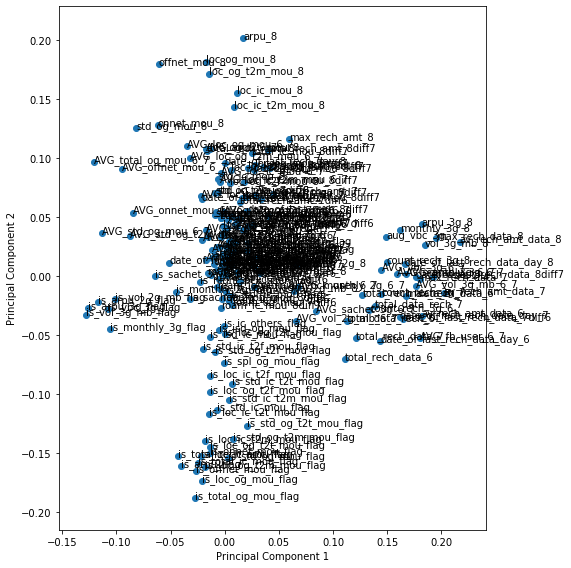

In [156]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

In [157]:
pca.explained_variance_ratio_

array([7.54352837e-02, 5.22263371e-02, 3.80054398e-02, 2.91606363e-02,
       2.59532987e-02, 2.22214036e-02, 2.06273760e-02, 1.93655524e-02,
       1.62638551e-02, 1.53717639e-02, 1.53082822e-02, 1.47440856e-02,
       1.40255654e-02, 1.34706342e-02, 1.33758923e-02, 1.31152711e-02,
       1.30682829e-02, 1.21921530e-02, 1.17847246e-02, 1.16954899e-02,
       1.13113057e-02, 1.08214657e-02, 1.06645754e-02, 1.03393507e-02,
       1.03004847e-02, 9.85796972e-03, 9.64915872e-03, 9.44187920e-03,
       9.29973679e-03, 9.05929060e-03, 8.94540618e-03, 8.76266481e-03,
       8.62955093e-03, 8.33525616e-03, 8.31342331e-03, 8.20076698e-03,
       8.16683999e-03, 7.99670956e-03, 7.86925782e-03, 7.68232051e-03,
       7.61055747e-03, 7.48886877e-03, 7.30364189e-03, 7.14279545e-03,
       7.01587439e-03, 6.93147685e-03, 6.81666294e-03, 6.74981807e-03,
       6.47122903e-03, 6.37785289e-03, 6.33580030e-03, 6.03108503e-03,
       5.89047840e-03, 5.84273770e-03, 5.77148864e-03, 5.65716034e-03,
      

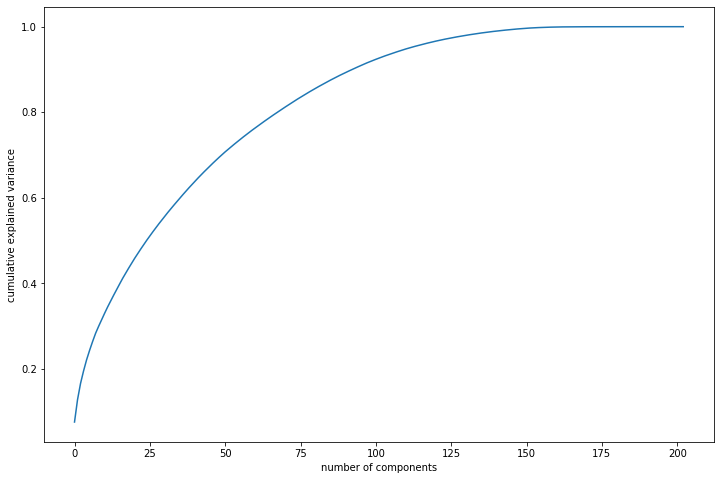

In [158]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [159]:
print("pca.explained_variance_ratio_: ",pca.explained_variance_ratio_.round(3)*100)

pca.explained_variance_ratio_:  [7.5 5.2 3.8 2.9 2.6 2.2 2.1 1.9 1.6 1.5 1.5 1.5 1.4 1.3 1.3 1.3 1.3 1.2
 1.2 1.2 1.1 1.1 1.1 1.  1.  1.  1.  0.9 0.9 0.9 0.9 0.9 0.9 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.6 0.6 0.6 0.6 0.6 0.6
 0.6 0.6 0.6 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0. ]


In [160]:
print (pca.explained_variance_ratio_.cumsum())

[0.07543528 0.12766162 0.16566706 0.1948277  0.220781   0.2430024
 0.26362978 0.28299533 0.29925918 0.31463095 0.32993923 0.34468331
 0.35870888 0.37217951 0.38555541 0.39867068 0.41173896 0.42393111
 0.43571584 0.44741133 0.45872263 0.4695441  0.48020867 0.49054803
 0.50084851 0.51070648 0.52035564 0.52979752 0.53909725 0.54815655
 0.55710195 0.56586462 0.57449417 0.58282942 0.59114285 0.59934361
 0.60751045 0.61550716 0.62337642 0.63105874 0.6386693  0.64615817
 0.65346181 0.6606046  0.66762048 0.67455196 0.68136862 0.68811844
 0.69458967 0.70096752 0.70730332 0.7133344  0.71922488 0.72506762
 0.73083911 0.73649627 0.74208537 0.74755826 0.75297948 0.75830994
 0.76349969 0.76864966 0.7737713  0.77878726 0.78376862 0.78868512
 0.79356247 0.79834216 0.80310265 0.80780714 0.81248582 0.81707732
 0.8216576  0.82617121 0.83067599 0.83500741 0.83932098 0.84357424
 0.84777627 0.85190632 0.85597278 0.85993761 0.86384439 0.86770249
 0.87150369 0.8752869  0.87896918 0.88256351 0.8860823  0.88952

In [161]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=54)

In [162]:
df_train_pca = pca_final.fit_transform(X_train)
df_train_pca.shape

(23962, 54)

In [163]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca.transpose())

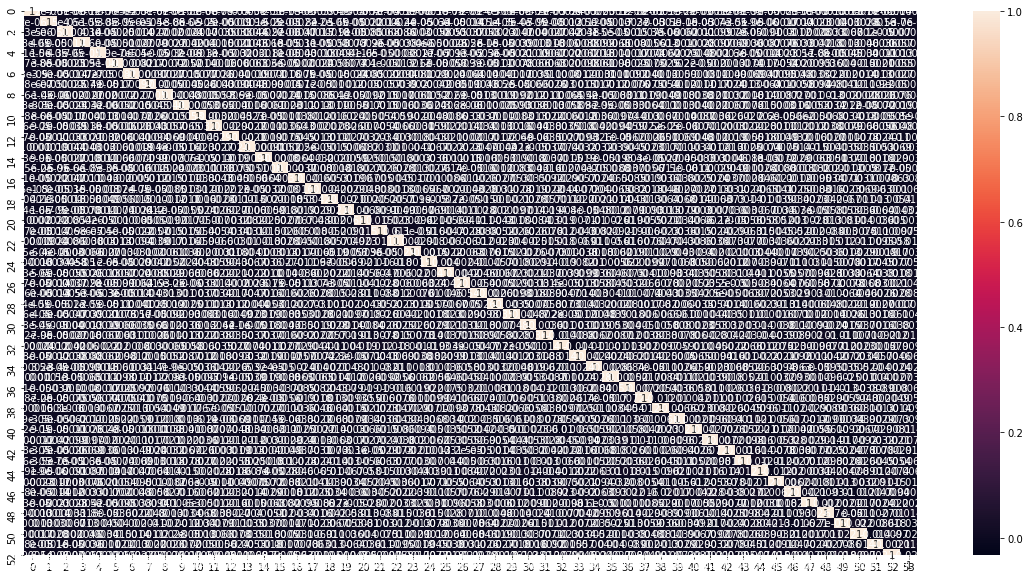

In [164]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)

In [165]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 0.028362129402157182 , min corr:  -0.03261009862686022


In [166]:
#Applying selected components to the test data
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(5991, 54)

<b>Logistic Regression</b>

Logistic Regression is a classification algorithm. It is used to predict a binary outcome or Multi class outcome, given a set of independent variables. Logistic regression is a special case of linear regression when the outcome variable is categorical, where we are using log of odds as dependent variable. In simple words, it predicts the probability of occurrence of an event by fitting data to a logit function.

Let's first fit a model with default hyperparameters.

In [168]:
#Training the model on the train data
from sklearn.linear_model import LogisticRegression

learner_pca = LogisticRegression()
model_pca = learner_pca.fit(df_train_pca,y_train)

In [169]:
#Making prediction on the test data
pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.89'

In [170]:
plotLiftChart(y_test.values,pred_probs_test,"Simple Logistic Regression")


NameError: name 'plotLiftChart' is not defined